In [ ]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.2 MB/s eta 0:00:00


In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1XP8hQkL69o5IZdoRb0GgcI0urgzUSb7x/view?usp=drivesdk" -O dataset.zip
!unzip -o dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/images/DJI_0189_JPG.rf.0507a7fd7e5391e08153a89c517e29f6.jpg  
  inflating: /content/train/images/DJI_0189_JPG.rf.6cf3c7bf2a6d5908cc1d167f439405f5.jpg  
  inflating: /content/train/images/DJI_0190_JPG.rf.3b148fe420d33aee9defc20dec9b0a51.jpg  
  inflating: /content/train/images/DJI_0190_JPG.rf.6e4df69f2e817b9e686fabb207e62d19.jpg  
  inflating: /content/train/images/DJI_0190_JPG.rf.daa460bb185951368fdaf74657214481.jpg  
  inflating: /content/train/images/DJI_0191_JPG.rf.515264bdf16c7fd57be255bd4601d853.jpg  
  inflating: /content/train/images/DJI_0191_JPG.rf.8c2f8fe5ed32974315718f8a824c4ede.jpg  
  inflating: /content/train/images/DJI_0191_JPG.rf.e7b6f5bcdfa2400599da5de200c6e6db.jpg  
  inflating: /content/train/images/DJI_0192_JPG.rf.0d59f6953e6e97b06e5040c988b05752.jpg  
  inflating: /content/train/images/DJI_0192_JPG.rf.990bdd9f5f5690316b670fe74772cf6c.jpg  
  inflating: /content/train/images/DJI_0192_JPG.r

In [ ]:
!ls

dataset.zip  data.yaml	sample_data  test  train  valid


In [ ]:
import os

paths = [
    "/content/train/images",
    "/content/train/labels",
    "/content/valid/images",
    "/content/valid/labels",
    "/content/test/images",
    "/content/test/labels",
]

for p in paths:
    print(p, "OK" if os.path.exists(p) else "MISSING")

/content/train/images OK
/content/train/labels OK
/content/valid/images OK
/content/valid/labels OK
/content/test/images OK
/content/test/labels OK


In [ ]:
from ultralytics.utils.checks import check_yaml

print(check_yaml('data.yaml'))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
data.yaml


In [ ]:
import os
import yaml

# ---------- USER CONFIG ----------
# dataset root where train/valid/test folders live and data.yaml is located
DATA_ROOT = "/content"            # change if needed
DATA_YAML = os.path.join(DATA_ROOT, "data.yaml")

# paths to label folders (these are the YOLO label directories)
LABEL_DIRS = [
    os.path.join(DATA_ROOT, "train", "labels"),
    os.path.join(DATA_ROOT, "valid", "labels"),
    os.path.join(DATA_ROOT, "test", "labels"),
]

# The transformations you requested:
REMOVE_NAMES = {"Bottle Cap", "Juice Box", "Plastic Waste"}  # classes to remove entirely
MERGE_MAP = {"Plastic": "Plastic Packaging"}      # source_name -> target_name
# ----------------------------------

def load_yaml(yaml_path):
    with open(yaml_path, "r") as f:
        return yaml.safe_load(f)

def save_yaml(data, yaml_path):
    with open(yaml_path, "w") as f:
        yaml.dump(data, f, default_flow_style=False, sort_keys=False)

def build_reindex_map(old_names_dict):
    """
    old_names_dict: {old_id: name}
    Returns:
      mapping: {old_id: new_id or None}
      new_names_list: [name0, name1, ...] in new index order
    """
    # Build a reverse map name -> old_id(s) (there might be duplicates but unlikely)
    old_items = sorted(old_names_dict.items(), key=lambda x: int(x[0]))  # list of (old_id, name)
    # Decide final order: iterate old ids ascending, skip removed, collapse merges
    new_names = []
    name_to_newid = {}

    # If a merge target doesn't yet exist among old names, we'll still create it when encountered.
    # But typical case: target exists already.
    for old_id, name in old_items:
        # Normalize name strings
        name = str(name).strip()

        # If the name is a source in merge_map, we will not add it now (it will map to target)
        if name in REMOVE_NAMES:
            continue

        if name in MERGE_MAP:
            # Source name — skip adding; handled when target encountered
            continue

        # If this name is a merge target and we haven't added it yet, add it.
        # Also this covers names that are neither removed nor merged
        if name in name_to_newid:
            # already added (maybe duplicate), skip
            continue

        # Add to new list (this keeps original relative ordering)
        name_to_newid[name] = len(new_names)
        new_names.append(name)

    # Ensure targets in MERGE_MAP are present even if the target name appears later or not at all
    for src, tgt in MERGE_MAP.items():
        if tgt not in name_to_newid:
            name_to_newid[tgt] = len(new_names)
            new_names.append(tgt)

    # Now build mapping old_id -> new_id or None
    mapping = {}
    for old_id, name in old_items:
        name = str(name).strip()

        if name in REMOVE_NAMES:
            mapping[int(old_id)] = None
            continue

        # If the name is a merge source, map to the new id of its target
        if name in MERGE_MAP:
            target_name = MERGE_MAP[name]
            new_id = name_to_newid.get(target_name)
            mapping[int(old_id)] = new_id
            continue

        # Normal kept class
        new_id = name_to_newid.get(name)
        if new_id is None:
            # Shouldn't happen, but guard
            mapping[int(old_id)] = None
        else:
            mapping[int(old_id)] = new_id

    return mapping, new_names

def fix_label_file(path, mapping):
    """
    Reads a YOLO label file and rewrites it applying 'mapping' from old->new.
    If a line maps to None, the annotation is dropped.
    """
    with open(path, "r") as f:
        lines = [l.strip() for l in f if l.strip()]

    new_lines = []
    for line in lines:
        parts = line.split()
        # Expect at least 5 parts: class x y w h
        if len(parts) < 5:
            continue
        try:
            old_id = int(parts[0])
        except ValueError:
            # malformed class id
            continue
        new_id = mapping.get(old_id, None)
        if new_id is None:
            # drop this annotation
            continue
        parts[0] = str(new_id)
        new_lines.append(" ".join(parts))

    # overwrite file
    with open(path, "w") as f:
        if new_lines:
            f.write("\n".join(new_lines) + "\n")
        else:
            # write empty file (YOLO expects empty or non-existing file for images with no boxes)
            f.write("")

def process_label_dirs(label_dirs, mapping):
    for d in label_dirs:
        if not os.path.isdir(d):
            print(f"Skipping (not found): {d}")
            continue
        print(f"Processing labels in: {d}")
        for fname in os.listdir(d):
            if not fname.endswith(".txt"):
                continue
            path = os.path.join(d, fname)
            fix_label_file(path, mapping)
        print(f"Done: {d}\n")

def main():
    if not os.path.exists(DATA_YAML):
        raise FileNotFoundError(f"data.yaml not found at {DATA_YAML}. Update DATA_ROOT or DATA_YAML variable.")

    # Load current YAML
    print("Loading YAML:", DATA_YAML)
    data = load_yaml(DATA_YAML)

    if "names" not in data:
        # Some data.yaml versions use list of names; normalize to dict
        raise KeyError("data.yaml does not contain 'names' key. Please ensure it's a standard YOLO data.yaml.")

    # Normalize names to dict of str(old_id) -> name (preserve original)
    # Some yamls store names as list (index -> name), some as dict (id: name).
    raw_names = data["names"]
    if isinstance(raw_names, list):
        old_names_dict = {i: raw_names[i] for i in range(len(raw_names))}
    elif isinstance(raw_names, dict):
        # keys might be strings or ints
        old_names_dict = {int(k): v for k, v in raw_names.items()}
    else:
        raise TypeError("Unsupported 'names' format in data.yaml (expect list or dict)")

    print("Old class list (id: name):")
    for k in sorted(old_names_dict.keys()):
        print(f"  {k}: {old_names_dict[k]}")

    # Build mapping and new names list
    mapping, new_names = build_reindex_map(old_names_dict)

    print("\nMapping (old_id -> new_id or None):")
    for old_id in sorted(mapping.keys()):
        print(f"  {old_id} -> {mapping[old_id]}")

    print("\nNew class list (index: name):")
    for i, n in enumerate(new_names):
        print(f"  {i}: {n}")

    # Apply mapping to all label directories
    process_label_dirs(LABEL_DIRS, mapping)

    # Update data.yaml
    # New names should be written as dict {0: 'name0', 1: 'name1', ...}
    new_names_dict = {i: name for i, name in enumerate(new_names)}
    data['nc'] = len(new_names)
    data['names'] = new_names_dict

    save_yaml(data, DATA_YAML)
    print(f"\nUpdated data.yaml written to: {DATA_YAML}")
    print(f"New nc = {data['nc']}")
    print("New names:", data['names'])

if __name__ == "__main__":
    main()


Loading YAML: /content/data.yaml
Old class list (id: name):
  0: Bottle Cap
  2: Juice Box
  4: Plastic
  5: Plastic Bag
  6: Plastic Bottle
  7: Plastic Waste
  8: Plastic Cup
  9: Plastic Packaging
  11: Undefined Trash

Mapping (old_id -> new_id or None):
  0 -> None
  2 -> None
  4 -> 3
  5 -> 0
  6 -> 1
  7 -> None
  8 -> 2
  9 -> 3
  11 -> 4

New class list (index: name):
  0: Plastic Bag
  1: Plastic Bottle
  2: Plastic Cup
  3: Plastic Packaging
  4: Undefined Trash
Processing labels in: /content/train/labels
Done: /content/train/labels

Processing labels in: /content/valid/labels
Done: /content/valid/labels

Processing labels in: /content/test/labels
Done: /content/test/labels


Updated data.yaml written to: /content/data.yaml
New nc = 5
New names: {0: 'Plastic Bag', 1: 'Plastic Bottle', 2: 'Plastic Cup', 3: 'Plastic Packaging', 4: 'Undefined Trash'}


In [ ]:
import yaml

with open("data.yaml", "r") as f:
    print(f.read())

train: ../train/images
val: ../valid/images
test: ../test/images
nc: 5
names:
  0: Plastic Bag
  1: Plastic Bottle
  2: Plastic Cup
  3: Plastic Packaging
  4: Undefined Trash



In [ ]:
from ultralytics import YOLO
model = YOLO('yolov9m.pt')
results = model.train(data='data.yaml', epochs=100)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

Confusion Matrix:


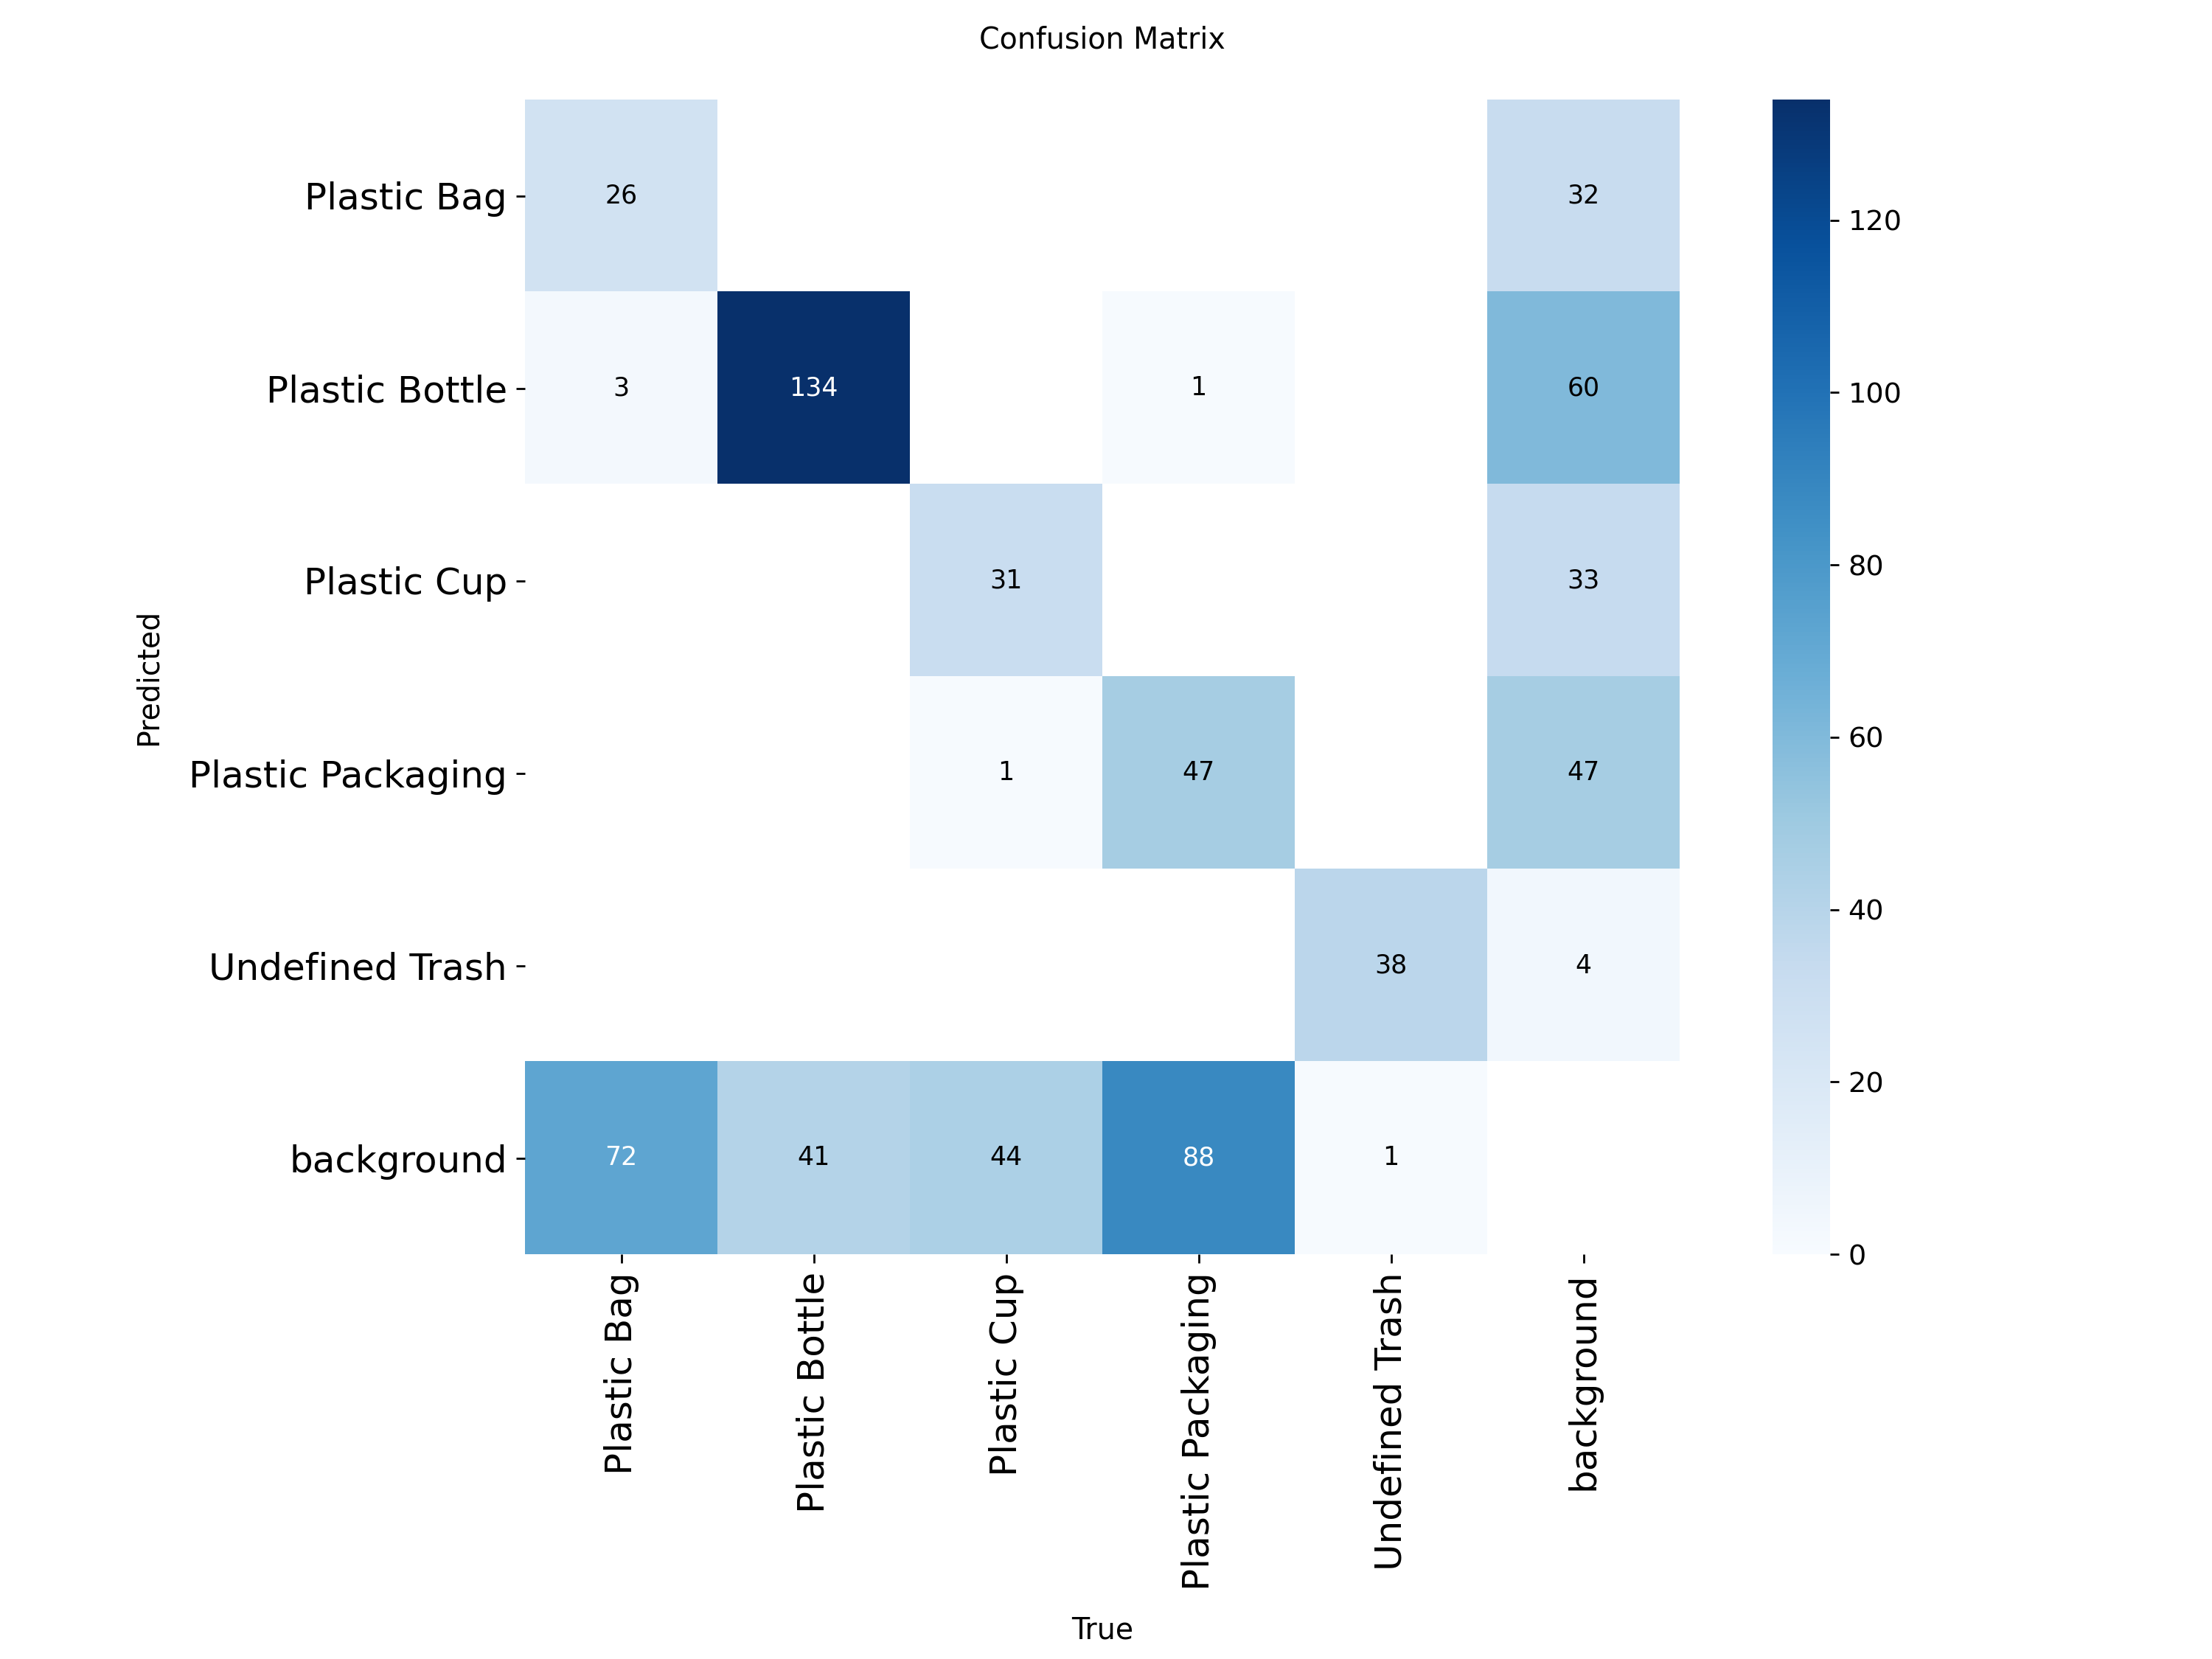

Results Plot:


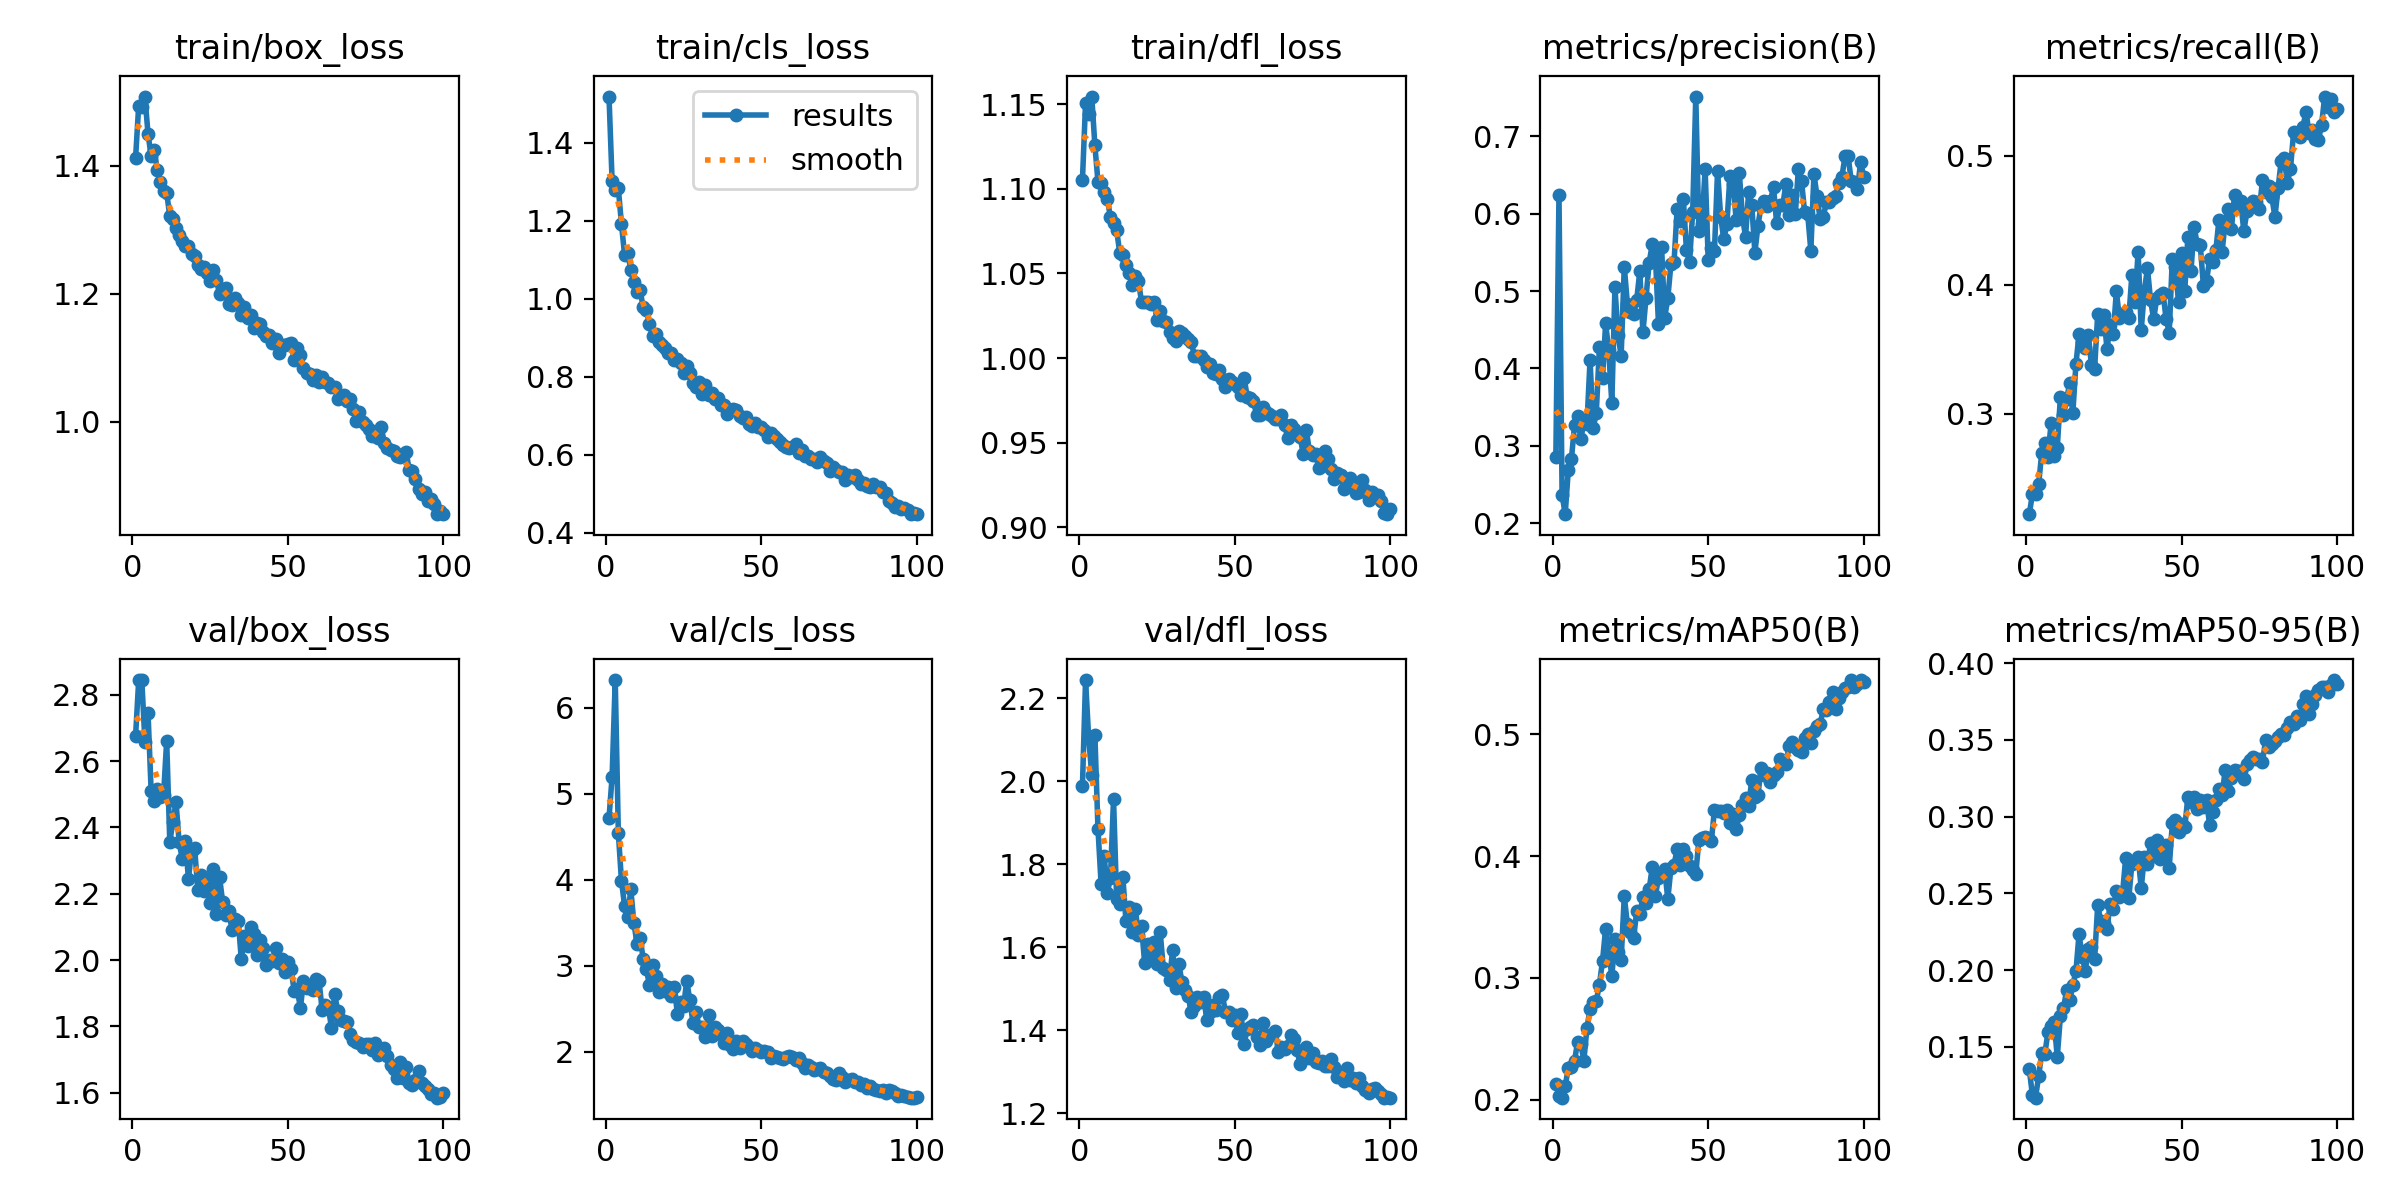

Example Validation Batch Images:


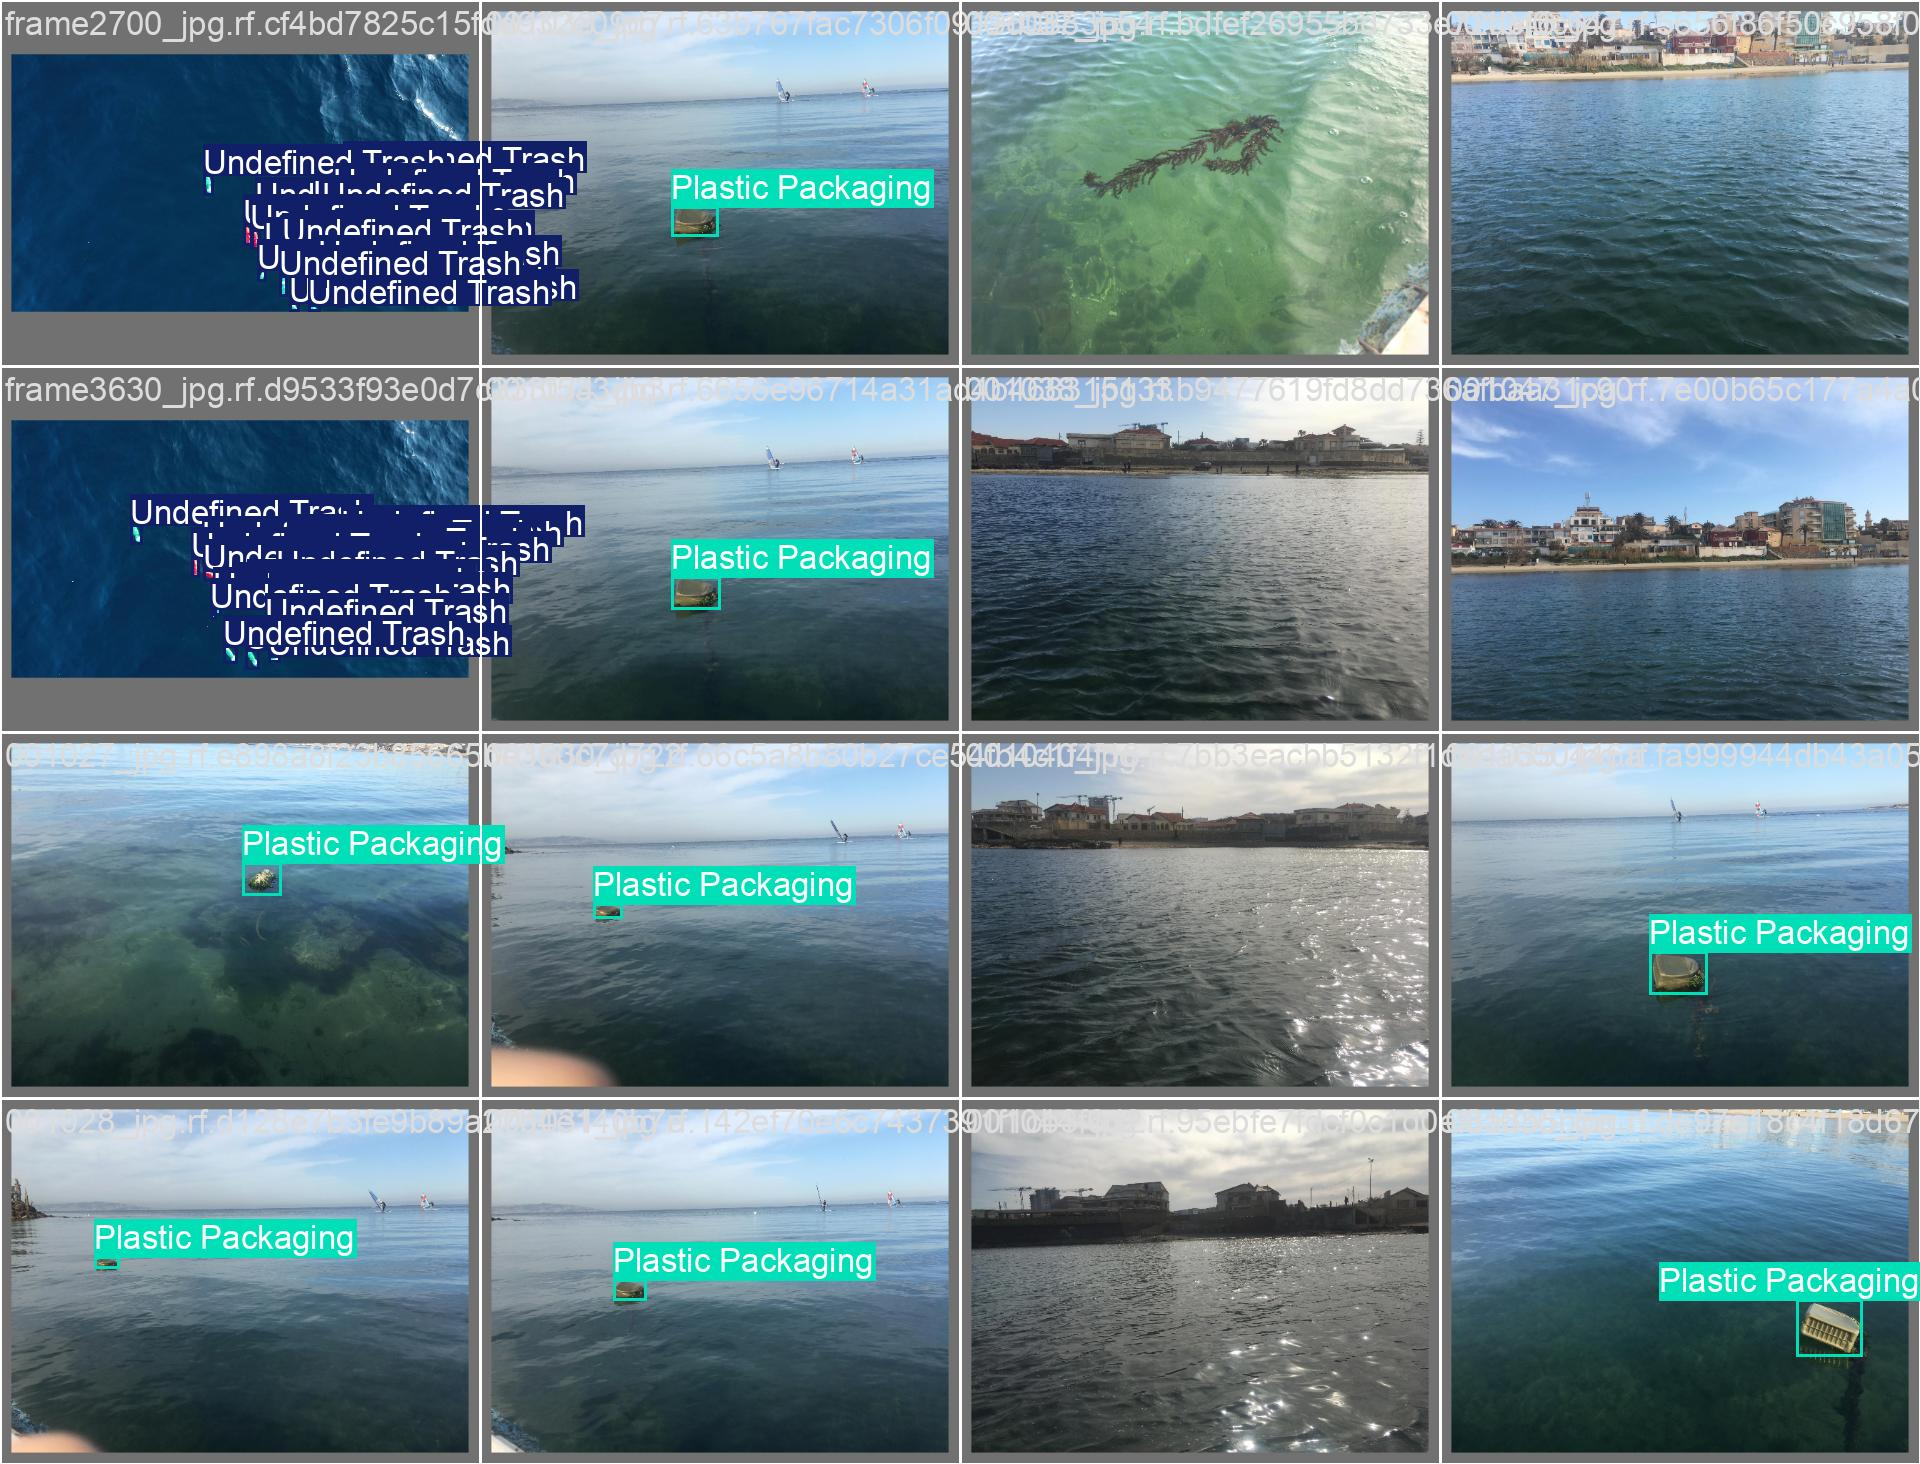

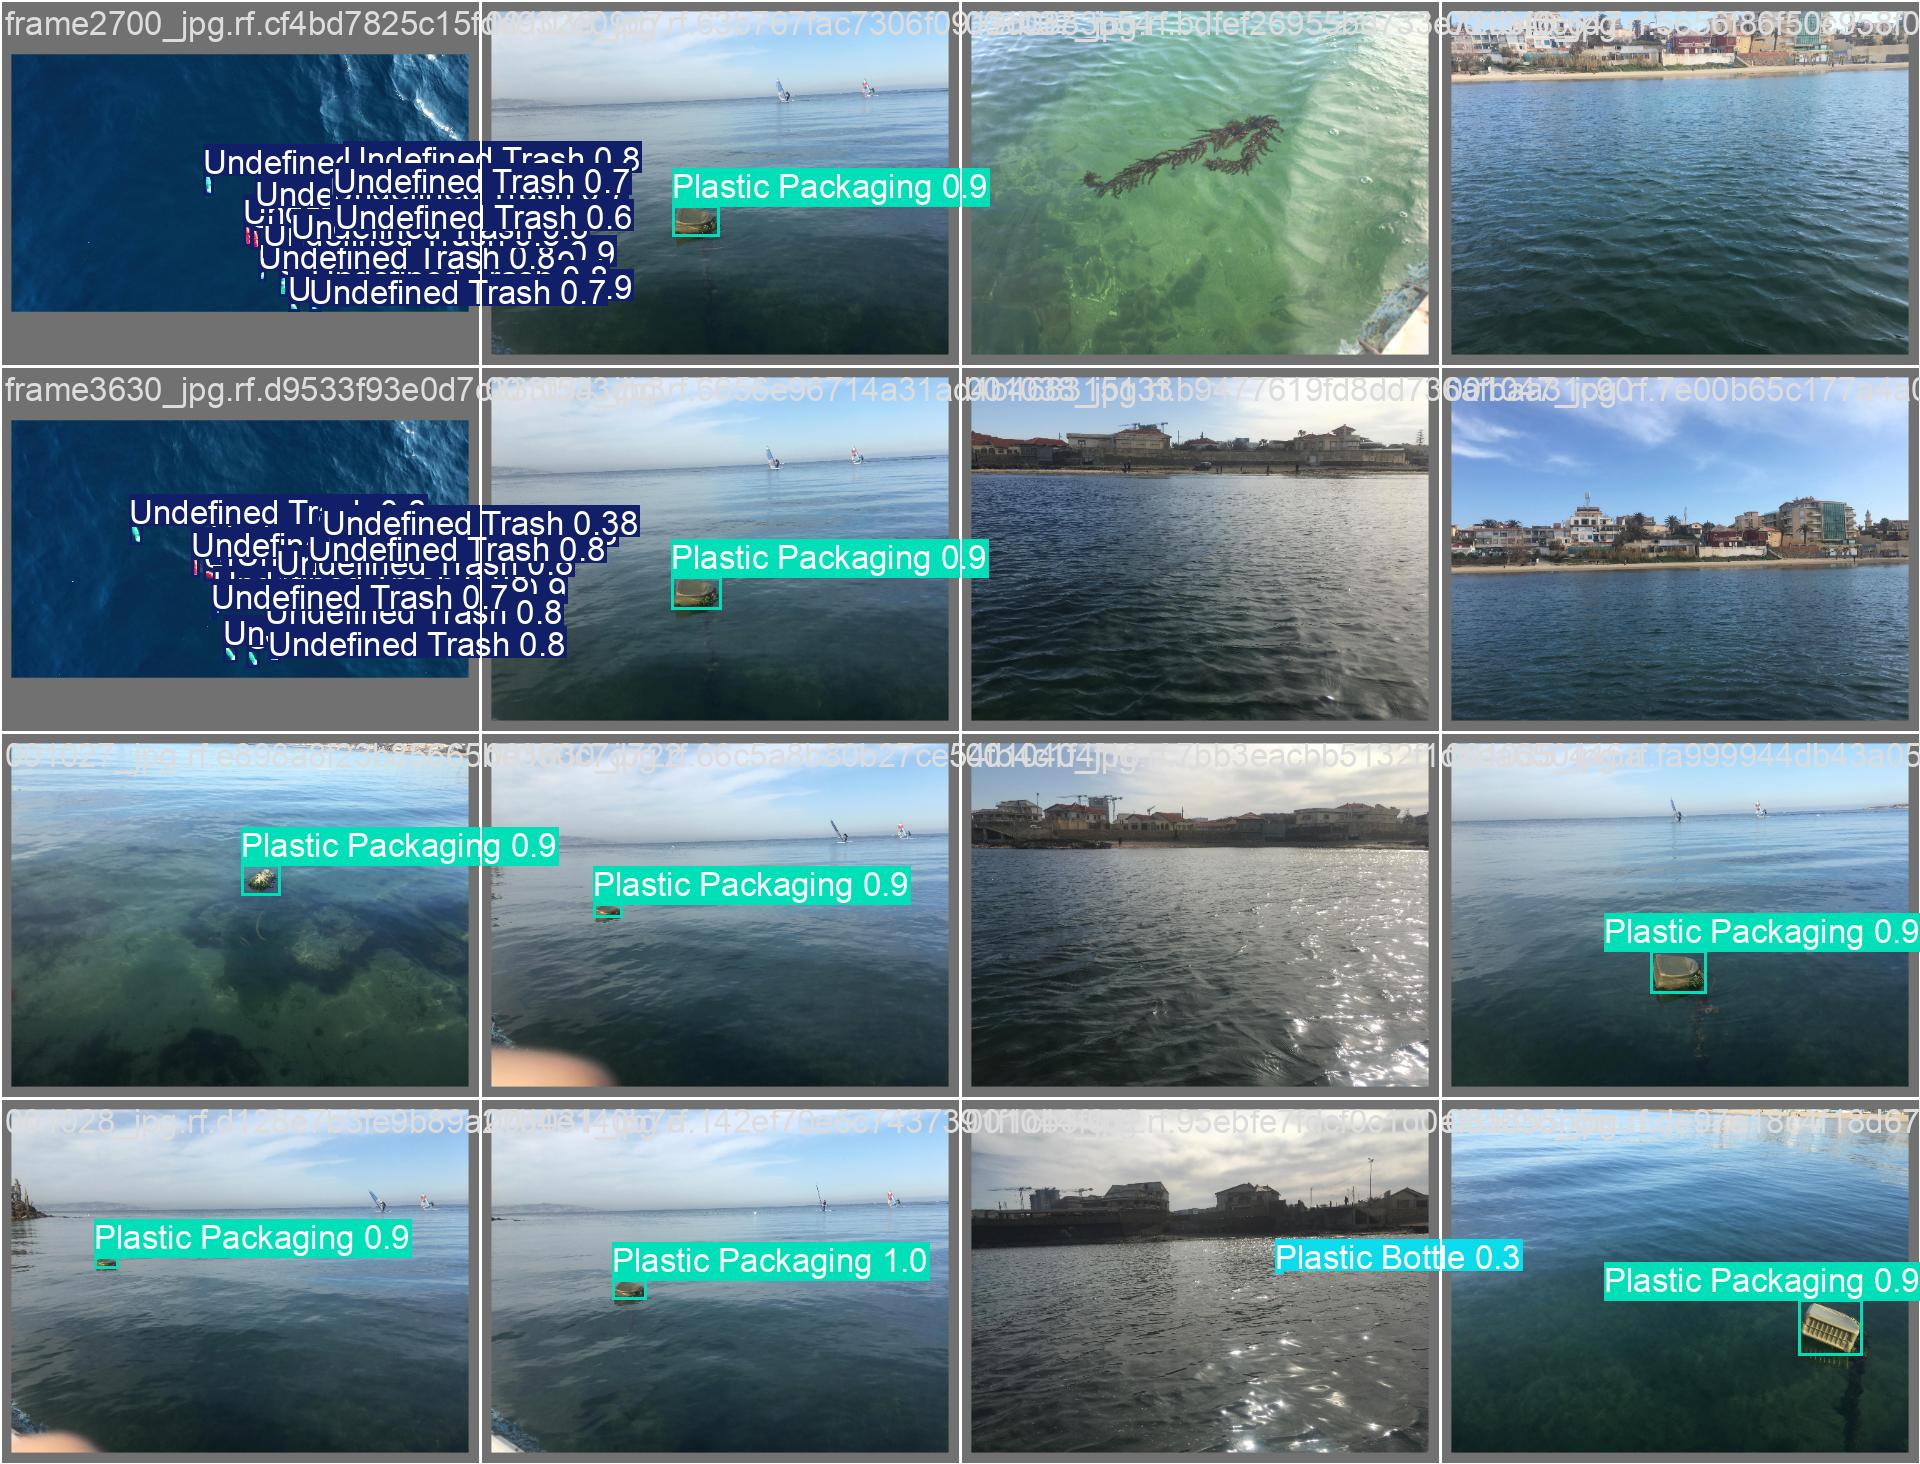

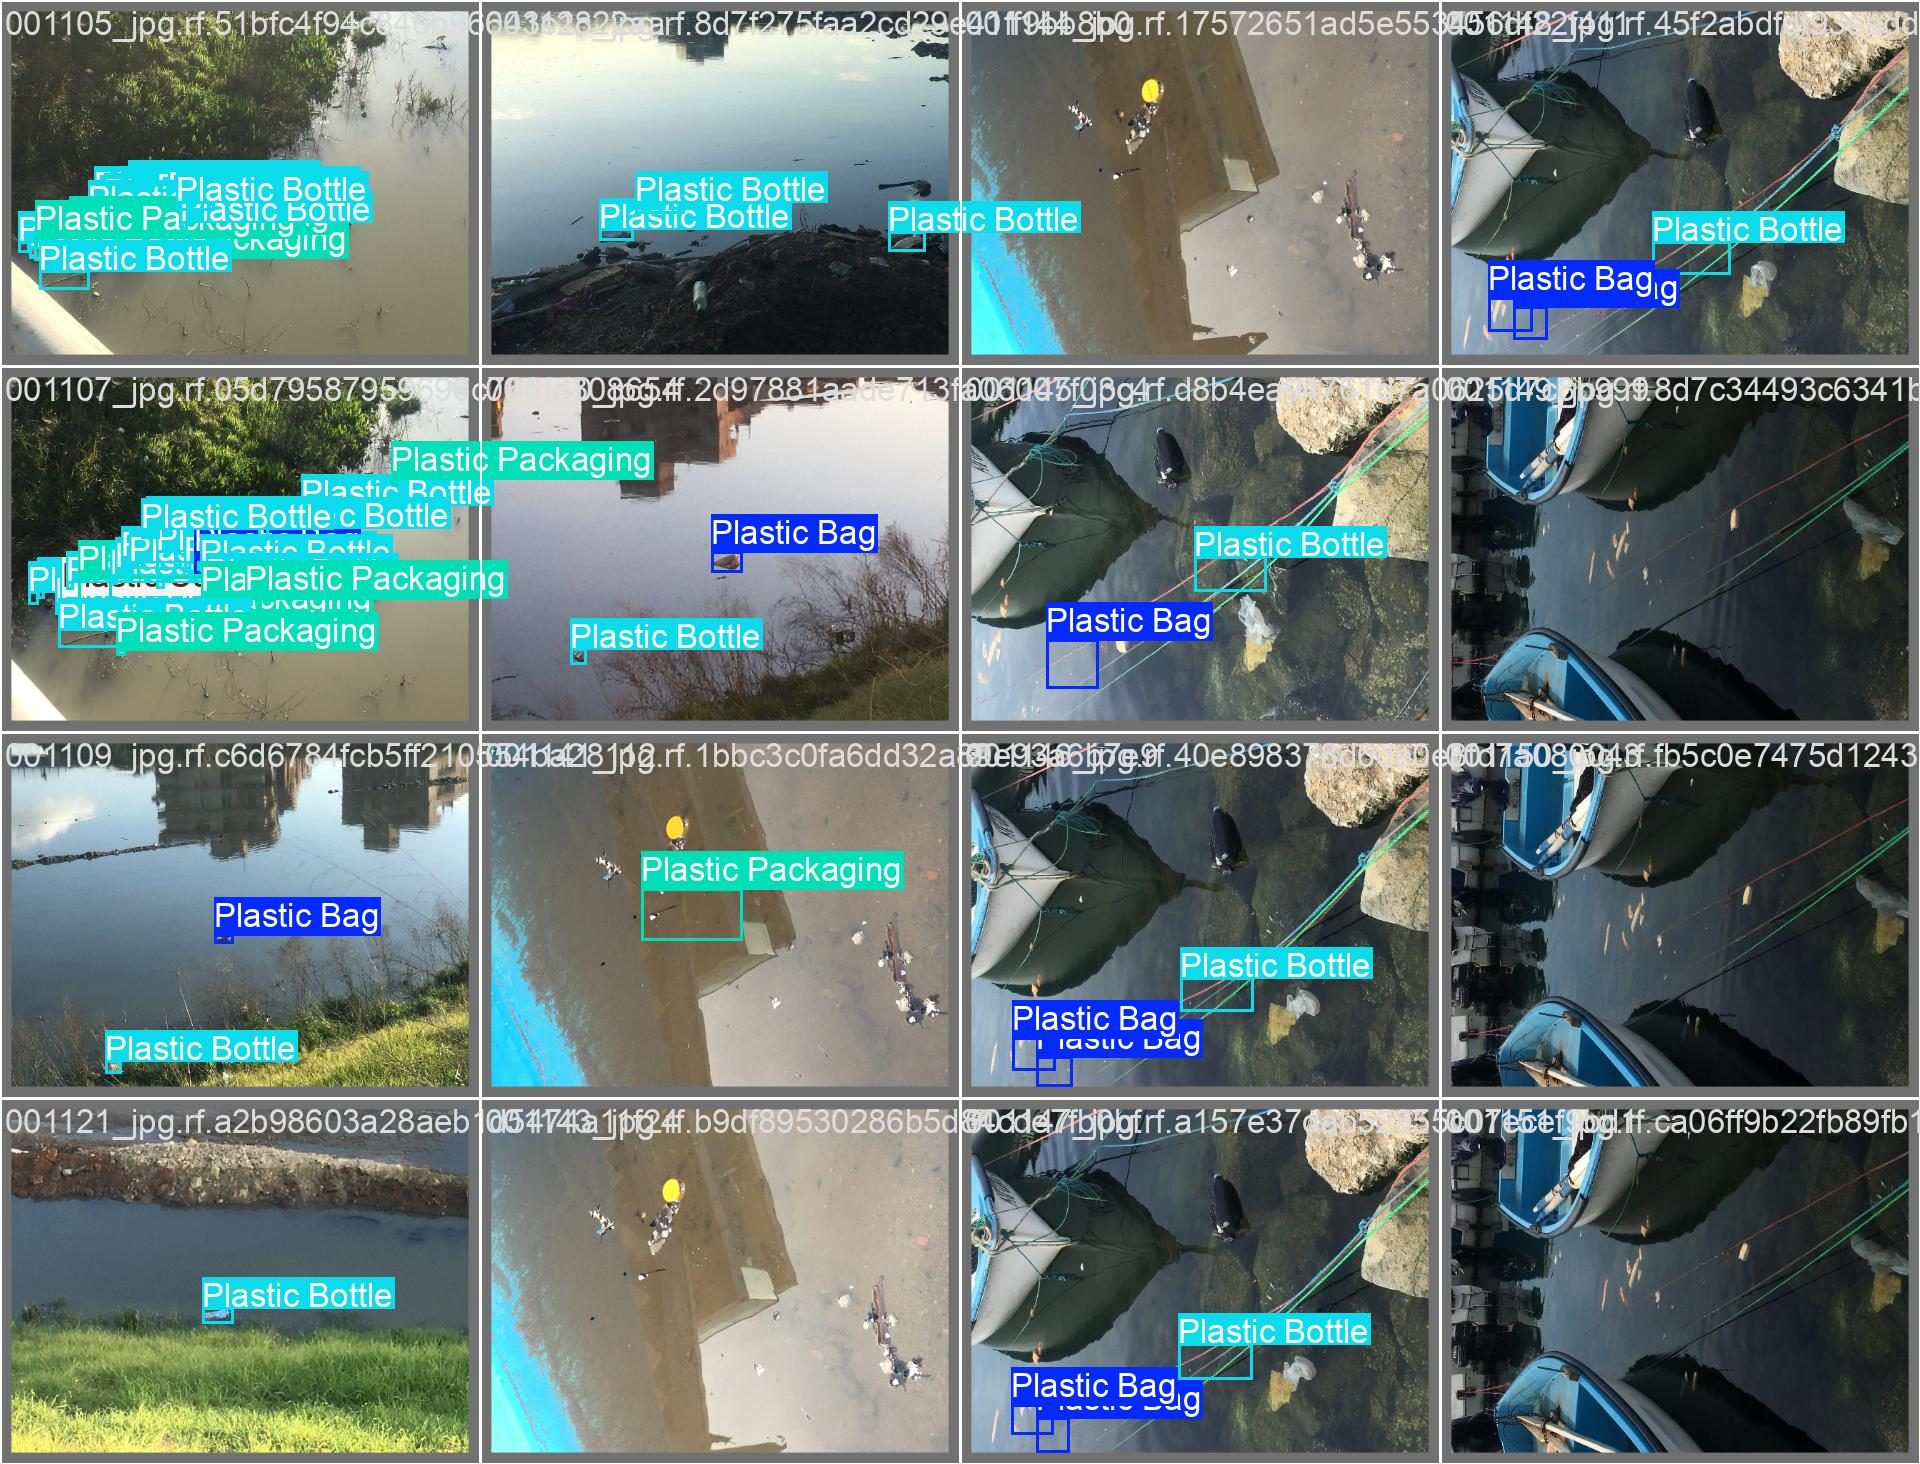

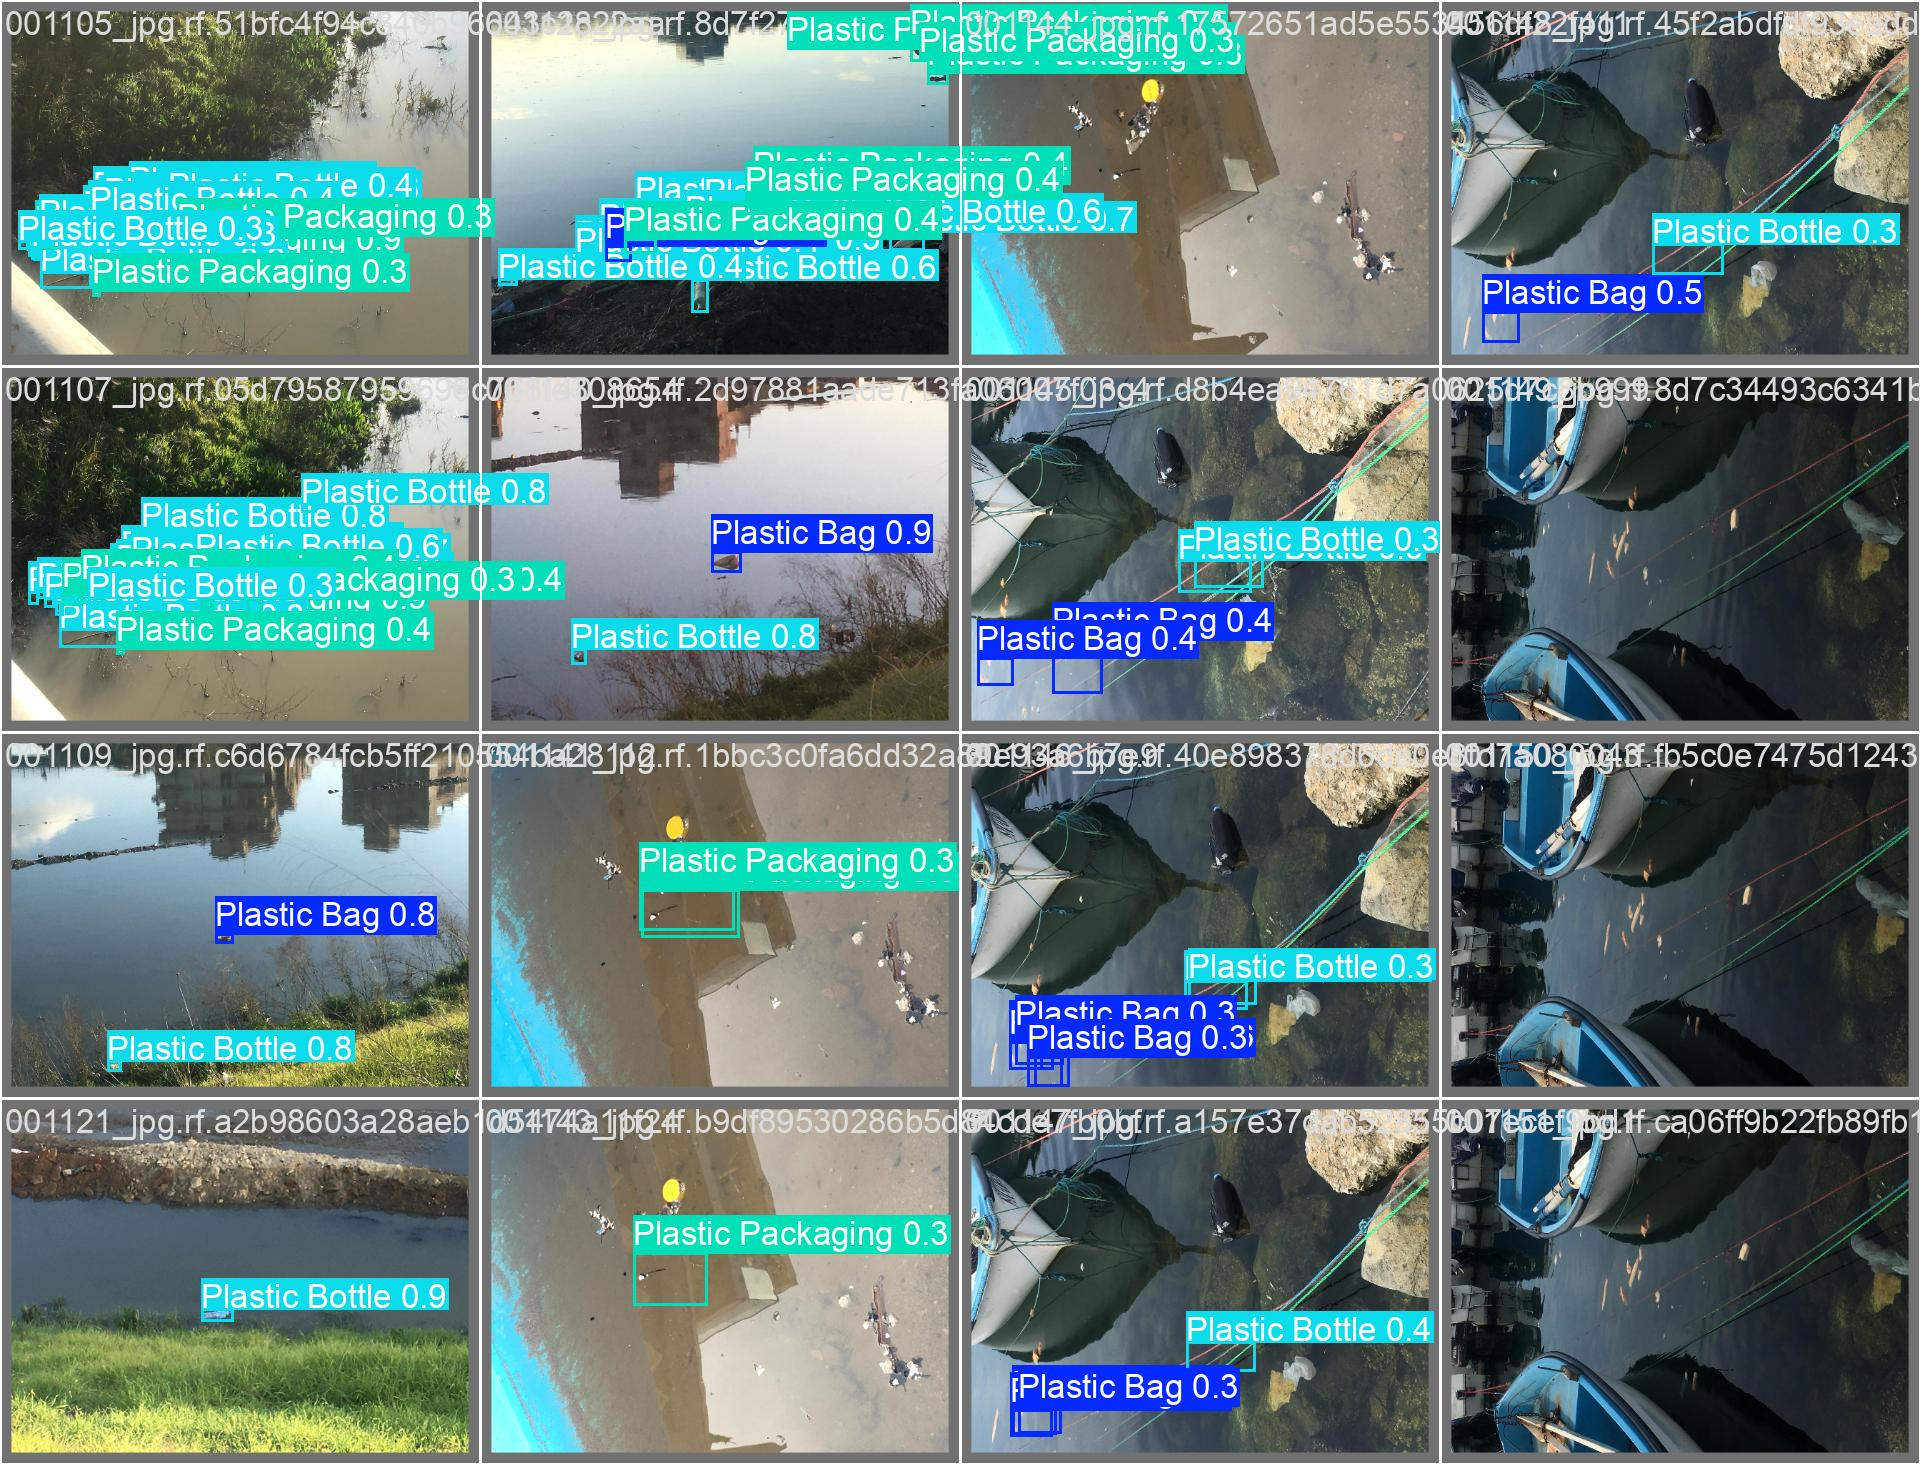

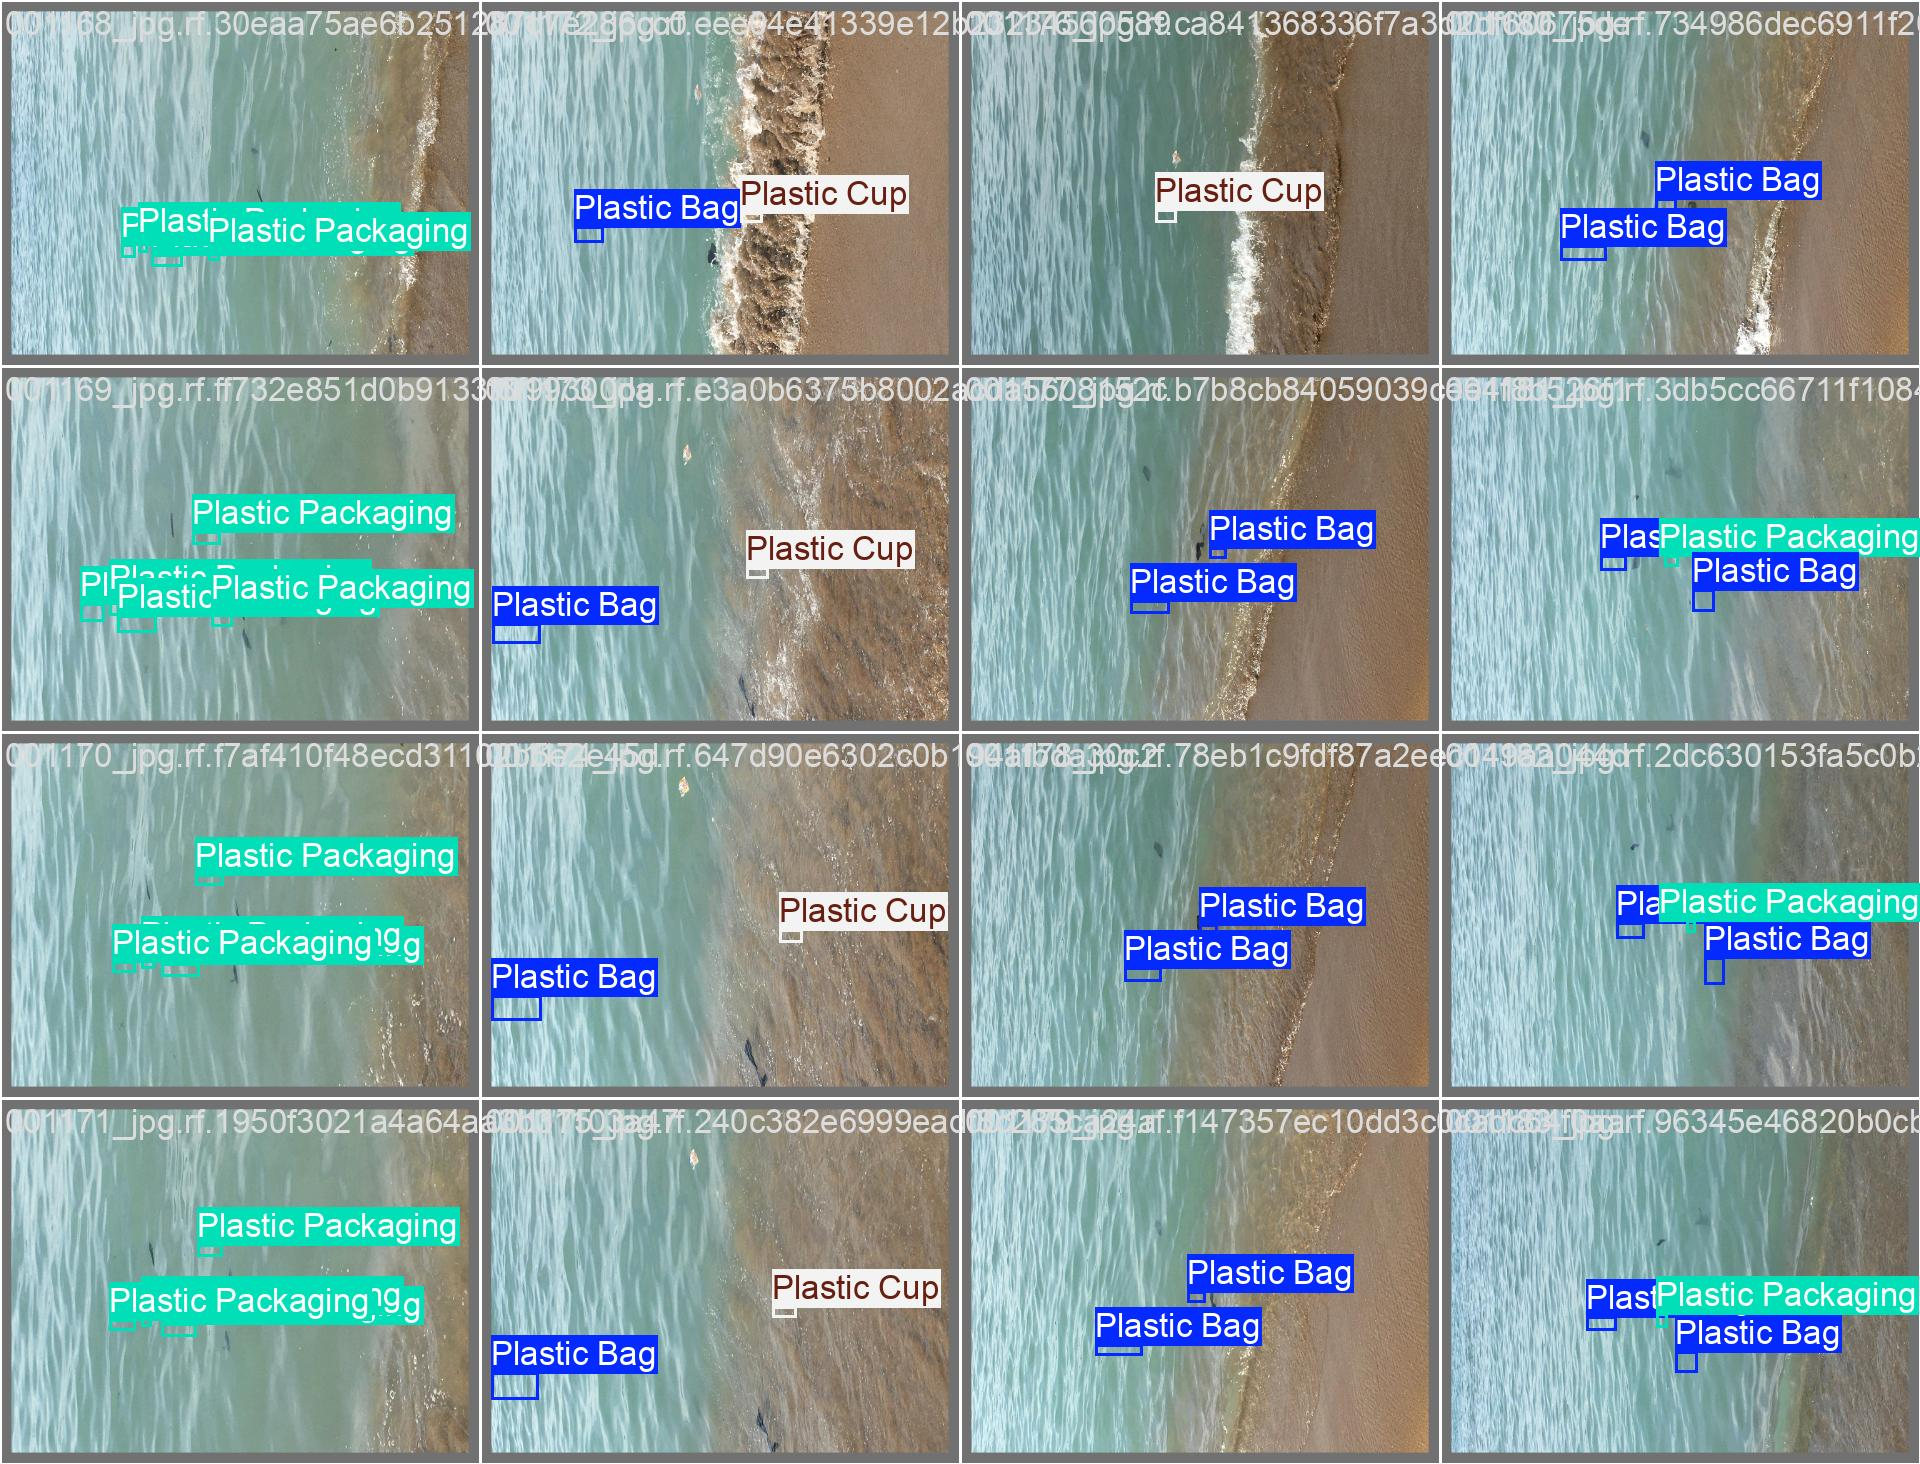

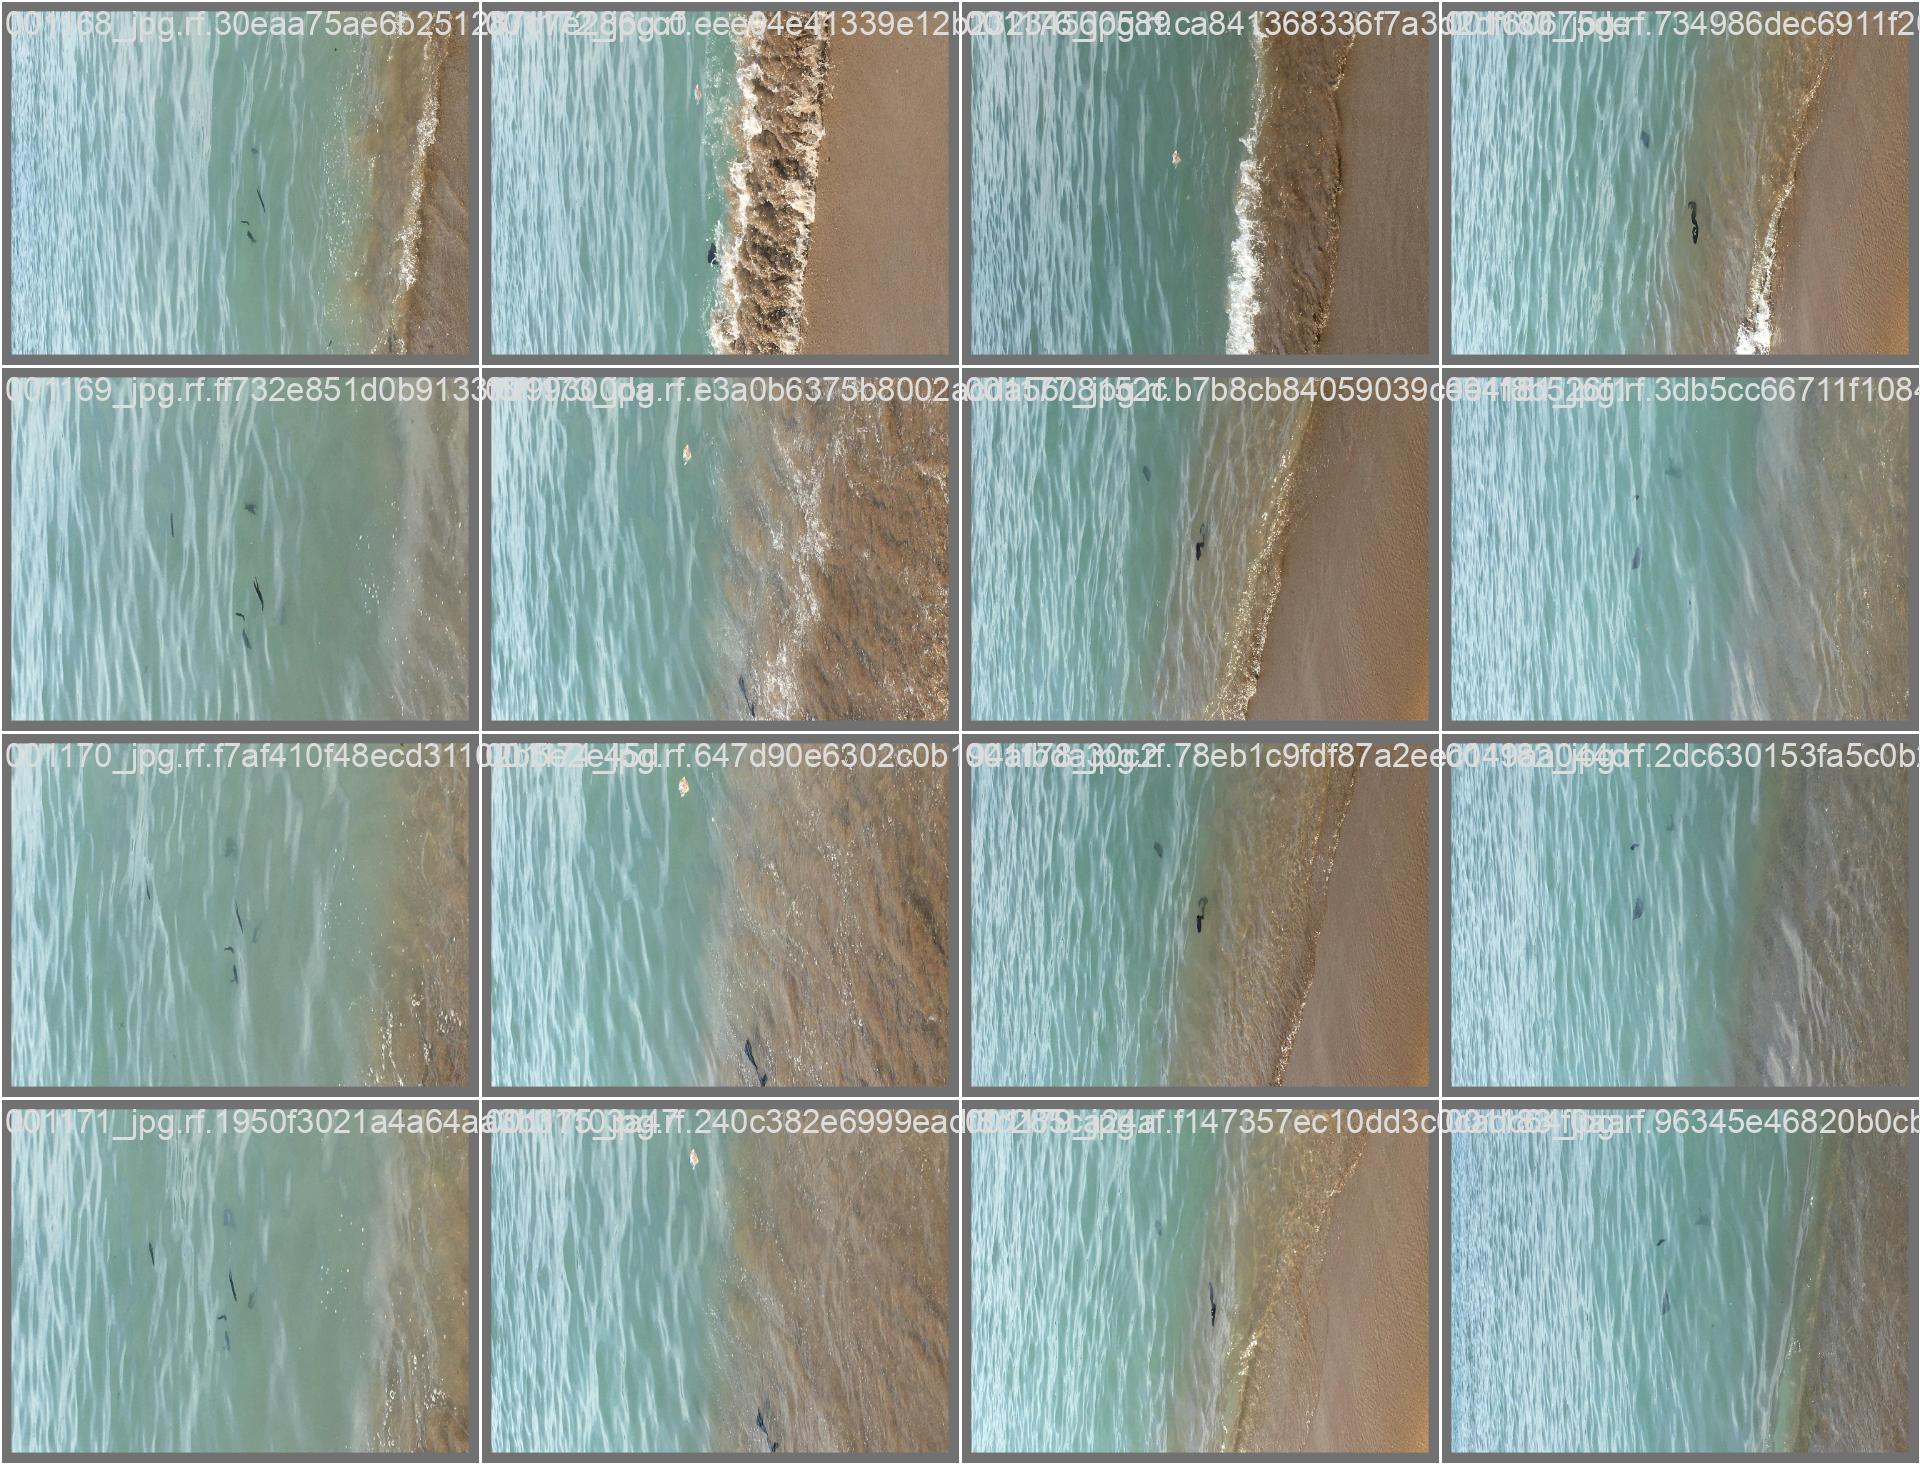

In [ ]:
import glob
from IPython.display import Image, display

results_dir = glob.glob('runs/detect/train*')[-1]
print("Confusion Matrix:")
display(Image(filename=f'{results_dir}/confusion_matrix.png'))
print("Results Plot:")
display(Image(filename=f'{results_dir}/results.png'))

print("Example Validation Batch Images:")
for f in sorted(glob.glob(f'{results_dir}/val_batch*.jpg')):
    display(Image(filename=f))


image 1/1 /content/train/images/001033_jpg.rf.63b767fac7306f0919d0883b546d1463.jpg: 480x640 1 Plastic Packaging, 92.6ms
Speed: 3.8ms preprocess, 92.6ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 640)
Displaying inference results for: /content/train/images/001033_jpg.rf.63b767fac7306f0919d0883b546d1463.jpg


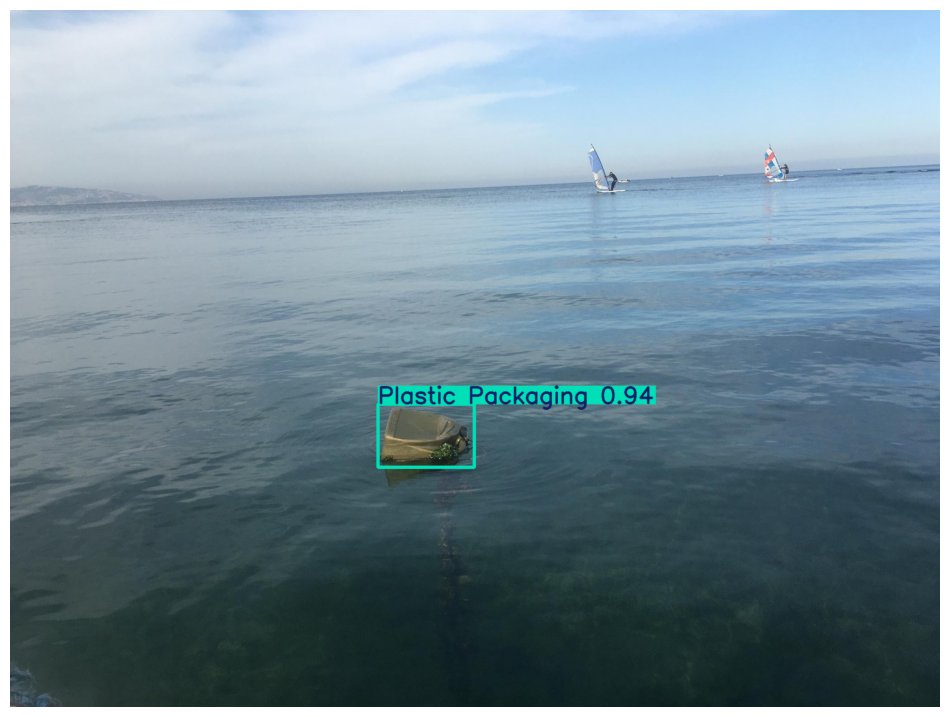

In [ ]:
import os
import random
import cv2
from PIL import Image
import matplotlib.pyplot as plt

test_image_paths = [os.path.join('test/images', f) for f in os.listdir('test/images') if f.endswith(('.jpg', '.jpeg', '.png'))]
# random_image_path = random.choice(test_image_paths)
random_image_path = '/content/train/images/001033_jpg.rf.63b767fac7306f0919d0883b546d1463.jpg'
results = model.predict(random_image_path)
res_plotted = results[0].plot()
res_plotted_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

print(f"Displaying inference results for: {random_image_path}")
plt.figure(figsize=(12, 12))
plt.imshow(res_plotted_rgb)
plt.axis('off')
plt.show()

In [ ]:
# Zip the entire runs folder
!zip -r runs.zip runs

# Download the zip file
from google.colab import files
files.download("runs.zip")


  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/val_batch1_labels.jpg (deflated 6%)
  adding: runs/detect/train/BoxR_curve.png (deflated 9%)
  adding: runs/detect/train/train_batch2.jpg (deflated 4%)
  adding: runs/detect/train/val_batch2_labels.jpg (deflated 6%)
  adding: runs/detect/train/val_batch1_pred.jpg (deflated 6%)
  adding: runs/detect/train/BoxPR_curve.png (deflated 10%)
  adding: runs/detect/train/confusion_matrix.png (deflated 22%)
  adding: runs/detect/train/confusion_matrix_normalized.png (deflated 21%)
  adding: runs/detect/train/train_batch1.jpg (deflated 5%)
  adding: runs/detect/train/labels.jpg (deflated 25%)
  adding: runs/detect/train/val_batch2_pred.jpg (deflated 7%)
  adding: runs/detect/train/val_batch0_labels.jpg (deflated 8%)
  adding: runs/detect/train/train_batch20431.jpg (deflated 15%)
  adding: runs/detect/train/results.csv (deflated 61%)
  adding: runs/detect/train/BoxF1_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -rq9 runs.zip /content/runs

In [ ]:
!mkdir -p "/content/drive/MyDrive/thesis"
!cp runs.zip "/content/drive/MyDrive/thesis/runs_v9.zip"

In [ ]:
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import os
import cv2

In [ ]:
model = YOLO("best.pt")   # your trained YOLOv11 weights
classes = model.names     # class names from your project


FileNotFoundError: [Errno 2] No such file or directory: 'best.pt'

In [ ]:
!find /content -name "best.pt"

/content/runs/detect/train/weights/best.pt


In [ ]:
model = YOLO("/content/runs/detect/train/weights/best.pt")
classes = model.names


In [ ]:
val_dir = "/content/valid/images"

image_paths = [os.path.join(val_dir, x) for x in os.listdir(val_dir)
               if x.lower().endswith((".jpg", ".png", ".jpeg"))]

y_true = []
y_pred = []
y_prob = []

print("Running inference on validation images...")

for img_path in image_paths:

    # ---- Load GT label ----
    label_path = img_path.replace("images", "labels").rsplit(".", 1)[0] + ".txt"
    if not os.path.exists(label_path):
        continue

    with open(label_path, "r") as f:
        line = f.readline().strip()

    # Skip if label file is empty (no ground truth objects for this image)
    if not line:
        continue

    gt_class = int(line.split()[0])  # YOLO format: <class> x y w h
    y_true.append(gt_class)

    # ---- Prediction ----
    results = model(img_path)[0]

    if len(results.boxes) == 0:
        # If no detection, it's a misclassification for the ground truth object.
        # Assign a 'wrong' class for y_pred to reflect this, and zero probabilities.
        pred_class_for_no_detection = (gt_class + 1) % len(classes)
        y_pred.append(pred_class_for_no_detection)
        y_prob.append(np.zeros(len(classes))) # No confidence for a missed detection
        continue

    box = results.boxes[0]
    pred_class = int(box.cls.cpu().numpy())
    pred_score = float(box.conf.cpu().numpy())

    y_pred.append(pred_class)

    # probability vector
    prob_vector = np.zeros(len(classes))
    prob_vector[pred_class] = pred_score
    y_prob.append(prob_vector)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print("Inference complete.")

Running inference on validation images...

image 1/1 /content/valid/images/001156_jpg.rf.f9760e476788205e26a152810ea93bad.jpg: 480x640 1 Plastic Cup, 32.2ms
Speed: 4.4ms preprocess, 32.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/valid/images/001153_jpg.rf.6b60a5dd382fd476eab6232d2dfa0c4a.jpg: 480x640 1 Plastic Packaging, 31.1ms
Speed: 3.6ms preprocess, 31.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/valid/images/001178_jpg.rf.78eb1c9fdf87a2eec149aa044d6607d5.jpg: 480x640 (no detections), 31.1ms
Speed: 3.7ms preprocess, 31.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/valid/images/001206_jpg.rf.dc2fca002dc8edcb44e72a61682e168b.jpg: 480x640 (no detections), 27.4ms
Speed: 3.9ms preprocess, 27.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)



/tmp/ipython-input-910813072.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_class = int(box.cls.cpu().numpy())
/tmp/ipython-input-910813072.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_score = float(box.conf.cpu().numpy())


image 1/1 /content/valid/images/IMG20230209102604_jpg.rf.92c9fc45801939c62acc5be783770917.jpg: 640x640 1 Plastic Bottle, 35.7ms
Speed: 4.0ms preprocess, 35.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/IMG20230209102537_jpg.rf.597bb796fc12434d0a5f4e8978f1afa2.jpg: 640x640 1 Plastic Bottle, 34.4ms
Speed: 5.1ms preprocess, 34.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/valid/images/001184_jpg.rf.c3b402c93a6d82aa2a056e272e74c8e0.jpg: 480x640 (no detections), 27.6ms
Speed: 3.7ms preprocess, 27.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/valid/images/001231_jpg.rf.e243336df0ac78586b108923d8eae0c6.jpg: 480x640 1 Plastic Bag, 20.0ms
Speed: 2.5ms preprocess, 20.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/valid/images/001181_jpg.rf.3db5cc66711f1084bd124a756d747298.jpg: 480x640 (no detections), 19.2ms
Speed:

In [ ]:
import os

target = "val/images"
found_paths = []

for root, dirs, files in os.walk("/content"):
    if root.endswith(target):
        found_paths.append(root)

found_paths

[]

In [ ]:
import os

yolo_paths = []

for root, dirs, files in os.walk("/content"):
    if ("images" in dirs) and ("labels" in dirs):
        yolo_paths.append(root)

yolo_paths

['/content/train', '/content/test', '/content/valid']

Classes: ['Plastic Bag', 'Plastic Bottle', 'Plastic Cup', 'Plastic Packaging', 'Undefined Trash']
Running inference on 163 images...

image 1/1 /content/valid/images/001027_jpg.rf.e898a8f23b85665be350c7d722a0ba50.jpg: 480x640 1 Plastic Packaging, 31.7ms
Speed: 2.4ms preprocess, 31.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/valid/images/001028_jpg.rf.d128e7b3fe9b89a27b4e140b7eef8862.jpg: 480x640 1 Plastic Packaging, 31.0ms
Speed: 2.3ms preprocess, 31.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/valid/images/001030_jpg.rf.66c5a8b80b27ce54fb4c1f4f16ed8a55.jpg: 480x640 1 Plastic Packaging, 30.7ms
Speed: 2.2ms preprocess, 30.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/valid/images/001031_jpg.rf.142ef70e6c7437391f1cb3f6d222faa6.jpg: 480x640 1 Plastic Packaging, 30.4ms
Speed: 2.2ms preprocess, 30.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 

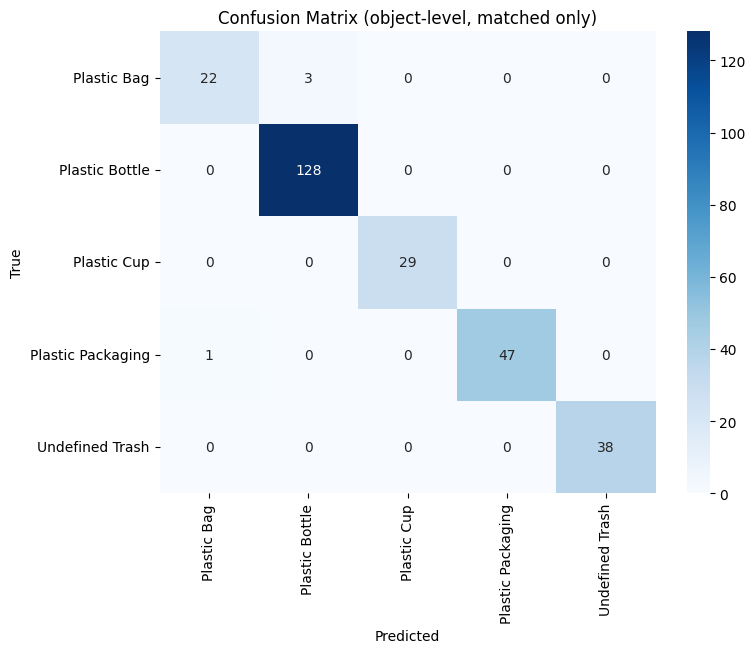

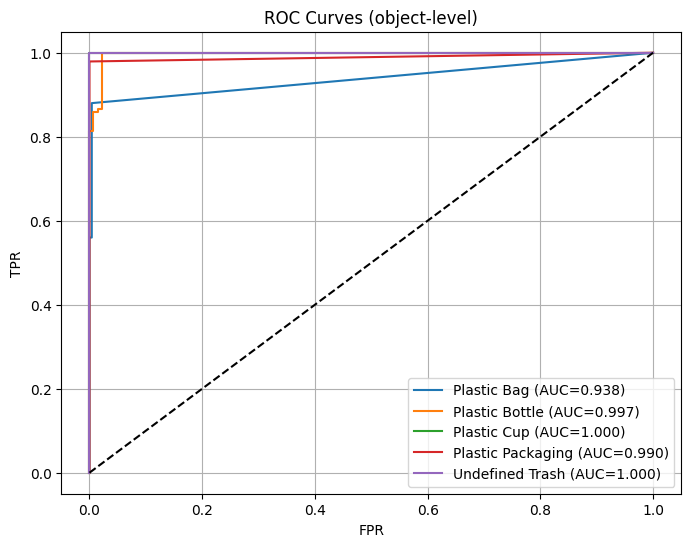

In [ ]:
# Robust YOLOv11 object-level evaluator with IoU matching
from ultralytics import YOLO
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---- config ----
WEIGHTS = "/content/runs/detect/train/weights/best.pt"   # <-- update if needed
val_dir = "/content/valid/images"                        # <-- auto-detect if needed
labels_root = val_dir.replace("images", "labels")        # expects siblings `labels`
IOU_THRESH = 0.5   # IoU threshold for matching preds->GT
# -----------------

model = YOLO(WEIGHTS)
classes = list(model.names.values()) if isinstance(model.names, dict) else list(model.names)
n_classes = len(classes)
print("Classes:", classes)

def read_yolo_label_file(label_path):
    """
    Read YOLO-format label file. Returns list of dicts: [{'cls': int, 'xywh': [x,y,w,h]}, ...]
    If file absent or empty -> returns empty list.
    """
    objs = []
    if not os.path.exists(label_path):
        return objs
    with open(label_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 5:
                continue
            try:
                cls = int(float(parts[0]))
                x = float(parts[1]); y = float(parts[2]); w = float(parts[3]); h = float(parts[4])
                objs.append({'cls': cls, 'xywh': [x,y,w,h]})
            except Exception:
                continue
    return objs

def xywh_norm_to_xyxy(xywh, img_w, img_h):
    # xywh normalized -> x1,y1,x2,y2 absolute
    x, y, w, h = xywh
    cx = x * img_w
    cy = y * img_h
    bw = w * img_w
    bh = h * img_h
    x1 = cx - bw/2
    y1 = cy - bh/2
    x2 = cx + bw/2
    y2 = cy + bh/2
    return [x1, y1, x2, y2]

def iou_xyxy(box1, box2):
    # box = [x1,y1,x2,y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    inter = inter_w * inter_h
    area1 = max(0, box1[2]-box1[0]) * max(0, box1[3]-box1[1])
    area2 = max(0, box2[2]-box2[0]) * max(0, box2[3]-box2[1])
    union = area1 + area2 - inter
    return inter/union if union > 0 else 0.0

# Collect object-level lists
y_true_objects = []   # integer class ids
y_pred_objects = []   # predicted class for matched pred (or -1 for unmatched GT)
y_prob_objects = []   # probability vector for matched pred (len == n_classes)

image_paths = [os.path.join(val_dir, f) for f in sorted(os.listdir(val_dir))
               if f.lower().endswith(('.jpg','.jpeg','.png'))]

print(f"Running inference on {len(image_paths)} images...")

for img_path in image_paths:
    # read GT objects (may be zero)
    label_path = img_path.replace("/images/", "/labels/").rsplit(".",1)[0] + ".txt"
    gt_objs = read_yolo_label_file(label_path)

    # get image size (for converting normalized coords)
    import cv2
    im = cv2.imread(img_path)
    if im is None:
        print("Warning: couldn't read", img_path)
        continue
    img_h, img_w = im.shape[:2]

    # convert GT boxes to absolute xyxy
    gt_boxes = []
    for o in gt_objs:
        xyxy = xywh_norm_to_xyxy(o['xywh'], img_w, img_h)
        gt_boxes.append({'cls': o['cls'], 'xyxy': xyxy, 'matched': False})

    # run model (single image)
    res = model(img_path)[0]   # results object
    # extract all predicted boxes
    preds = []
    if hasattr(res, "boxes") and len(res.boxes) > 0:
        for b in res.boxes:
            # .xyxy, .conf, .cls - careful extraction
            xyxy = b.xyxy.cpu().numpy().tolist()[0] if hasattr(b, "xyxy") else None
            # for scalar attributes ensure to extract single element
            conf = float(b.conf.cpu().numpy().item()) if hasattr(b, "conf") else float(b.conf.item()) if hasattr(b, "conf") else 0.0
            cls = int(b.cls.cpu().numpy().item()) if hasattr(b, "cls") else int(b.cls.item())
            preds.append({'cls': cls, 'conf': conf, 'xyxy': xyxy, 'matched': False})

    # If there are GT objects, match preds to GTs using greedy highest-IoU matching
    if len(gt_boxes) > 0 and len(preds) > 0:
        # compute IoU matrix
        iou_mat = np.zeros((len(gt_boxes), len(preds)), dtype=float)
        for i_g, g in enumerate(gt_boxes):
            for j_p, p in enumerate(preds):
                iou_mat[i_g, j_p] = iou_xyxy(g['xyxy'], p['xyxy'])
        # Greedy matching: while max IoU > IOU_THRESH, match that pair, mark them used
        while True:
            idx = np.unravel_index(np.argmax(iou_mat), iou_mat.shape)
            max_iou = iou_mat[idx]
            if max_iou < IOU_THRESH:
                break
            g_i, p_j = idx
            # record match
            gt_boxes[g_i]['matched'] = True
            preds[p_j]['matched'] = True
            # Append object-level true/pred/prob
            true_cls = gt_boxes[g_i]['cls']
            pred_cls = preds[p_j]['cls']
            conf = preds[p_j]['conf']
            prob_vec = np.zeros(n_classes, dtype=float)
            prob_vec[pred_cls] = conf
            y_true_objects.append(true_cls)
            y_pred_objects.append(pred_cls)
            y_prob_objects.append(prob_vec)
            # Invalidate row and column to avoid reuse
            iou_mat[g_i, :] = -1.0
            iou_mat[:, p_j] = -1.0

    # Unmatched GTs => missed detections (treat pred as -1 or a special background)
    for g in gt_boxes:
        if not g.get('matched', False):
            y_true_objects.append(g['cls'])
            y_pred_objects.append(-1)   # missed
            prob_vec = np.zeros(n_classes, dtype=float)
            y_prob_objects.append(prob_vec)

    # Unmatched preds => false positives (no GT matched) - record as predicted class vs true == -1
    for p in preds:
        if not p.get('matched', False):
            # we can optionally record false positives (no corresponding GT)
            # represent GT as -1 and prediction as p['cls'] - these won't be used in classification_report,
            # but could be used for detection-level FP stats. We'll skip adding to classification metrics for now.
            # If you want to include them, you'd need to define a "background" class id.
            pass

# Convert to numpy arrays for metrics
y_true_objects = np.array(y_true_objects)
y_pred_objects = np.array(y_pred_objects)
y_prob_objects = np.stack(y_prob_objects) if len(y_prob_objects) > 0 else np.zeros((0, n_classes))

print("Objects collected:", len(y_true_objects))
if len(y_true_objects) == 0:
    raise RuntimeError("No object matches or GT objects found. Check your label files and paths.")

# For classification_report and confusion matrix we need only matched GTs and predicted classes (exclude -1 missed preds maybe include as incorrect)
# Option A: Treat missed detection (-1) as predicted "background" — we will exclude them from classification report since background is not in classes.
mask_valid = (y_pred_objects != -1)  # only matched GTs
y_true_for_report = y_true_objects[mask_valid]
y_pred_for_report = y_pred_objects[mask_valid]
y_prob_for_report = y_prob_objects[mask_valid]

from sklearn.metrics import precision_recall_fscore_support

print("\n=== Classification Report (object-level, matched only) ===")
print(classification_report(y_true_for_report, y_pred_for_report, labels=np.arange(n_classes), target_names=classes))

# Confusion matrix (show counts for matched)
cm = confusion_matrix(y_true_for_report, y_pred_for_report, labels=np.arange(n_classes))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (object-level, matched only)")
plt.show()

# ROC-AUC (one-vs-rest) using probability vectors
y_true_bin = label_binarize(y_true_for_report, classes=np.arange(n_classes))
plt.figure(figsize=(8,6))
for i in range(n_classes):
    try:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob_for_report[:, i])
        auc = roc_auc_score(y_true_bin[:, i], y_prob_for_report[:, i])
    except ValueError:
        # happens when only one class present in slice
        fpr, tpr, auc = [0,1], [0,1], float('nan')
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves (object-level)"); plt.legend(); plt.grid(); plt.show()

In [ ]:
# Classification report (precision, recall, f1, support)
from sklearn.metrics import classification_report
import numpy as np

if 'y_true_for_report' not in globals() or len(y_true_for_report) == 0:
    print("No matched objects to report. Ensure y_true_for_report is non-empty.")
else:
    # y_true_for_report and y_pred_for_report are integer arrays
    print("=== Classification Report ===\n")
    print(classification_report(
        y_true_for_report,
        y_pred_for_report,
        labels=np.arange(len(classes)),
        target_names=classes,
        zero_division=0   # avoid warnings when a class has no predictions
    ))

=== Classification Report ===

                   precision    recall  f1-score   support

      Plastic Bag       0.96      0.88      0.92        25
   Plastic Bottle       0.98      1.00      0.99       128
      Plastic Cup       1.00      1.00      1.00        29
Plastic Packaging       1.00      0.98      0.99        48
  Undefined Trash       1.00      1.00      1.00        38

         accuracy                           0.99       268
        macro avg       0.99      0.97      0.98       268
     weighted avg       0.99      0.99      0.98       268



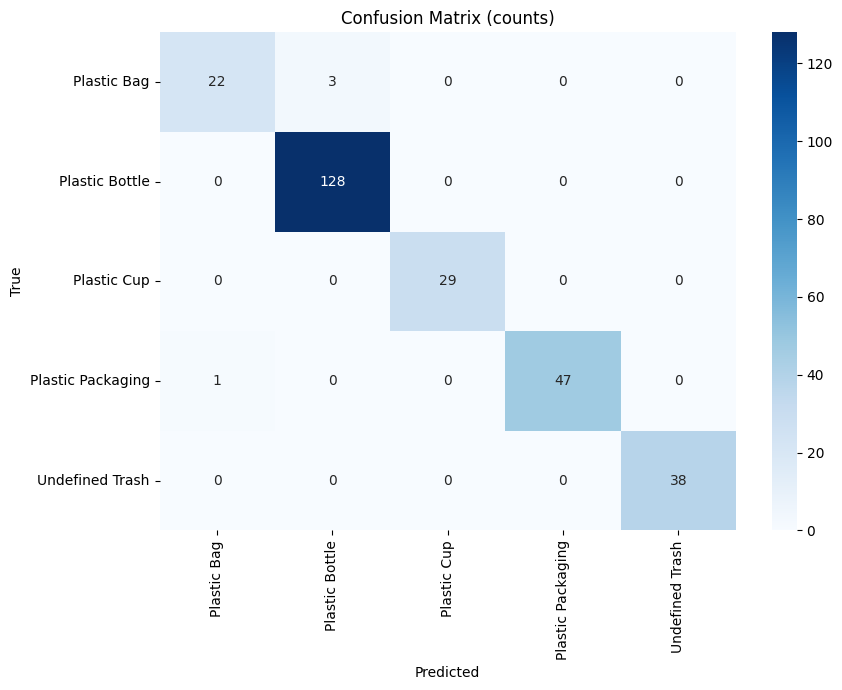

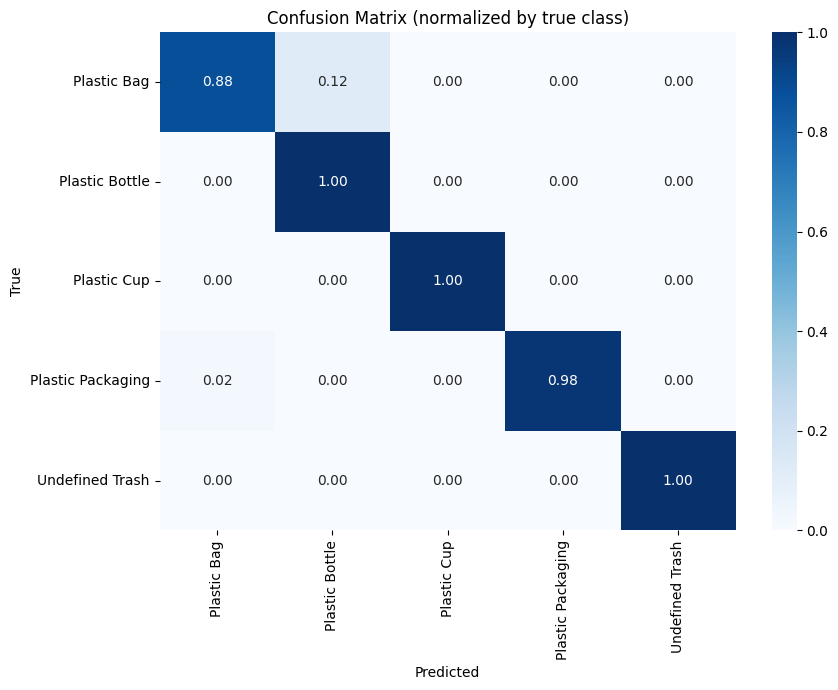

Saved normalized confusion matrix to ./eval_plots/confusion_matrix_normalized.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Confusion matrix with options: counts and normalized (by true class)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

if 'y_true_for_report' not in globals() or len(y_true_for_report) == 0:
    print("No matched objects to compute confusion matrix. Ensure y_true_for_report is non-empty.")
else:
    cm = confusion_matrix(y_true_for_report, y_pred_for_report, labels=np.arange(len(classes)))

    # Plot absolute counts
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (counts)")
    plt.tight_layout()
    plt.show()

    # Plot normalized by true class (recall per class)
    with np.errstate(all='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm)  # convert NaNs to 0 for plotting

    plt.figure(figsize=(9,7))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (normalized by true class)")
    plt.tight_layout()
    plt.show()

    # Optional: save to file
    out_dir = "./eval_plots"
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(os.path.join(out_dir, "confusion_matrix_normalized.png"))
    print(f"Saved normalized confusion matrix to {os.path.join(out_dir, 'confusion_matrix_normalized.png')}")

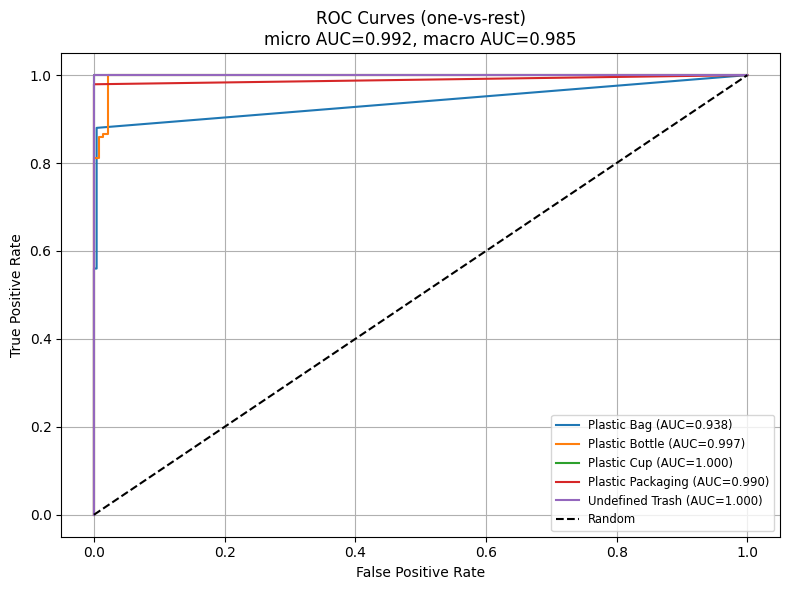

Saved ROC plot to ./eval_plots/roc_curves.png


In [ ]:
# ROC-AUC (One-vs-Rest). Requires y_prob_for_report as shape (N, n_classes)
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import os

if 'y_true_for_report' not in globals() or len(y_true_for_report) == 0:
    print("No matched objects to compute ROC-AUC. Ensure y_true_for_report is non-empty.")
elif 'y_prob_for_report' not in globals() or y_prob_for_report.shape[0] == 0:
    print("No probability vectors available in y_prob_for_report. Ensure it's non-empty and shape (N, n_classes).")
else:
    # Binarize true labels for one-vs-rest ROC
    y_true_bin = label_binarize(y_true_for_report, classes=np.arange(n_classes))
    if y_true_bin.shape[1] != n_classes:
        # If some classes are missing in this subset, pad columns to n_classes
        padded = np.zeros((y_true_bin.shape[0], n_classes), dtype=int)
        for i, cls in enumerate(np.unique(y_true_for_report)):
            padded[:, cls] = (y_true_for_report == cls).astype(int)
        y_true_bin = padded

    plt.figure(figsize=(8,6))
    aucs = []
    for i in range(n_classes):
        # guard: roc_curve requires both positive and negative samples for the class
        try:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob_for_report[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob_for_report[:, i])
            plt.plot(fpr, tpr, label=f"{classes[i]} (AUC={auc:.3f})")
            aucs.append(auc)
        except ValueError:
            # Only one class present in this slice -> skip plotting for that class
            print(f"Skipping ROC for class '{classes[i]}' (no positive or negative samples).")
            aucs.append(np.nan)

    # micro and macro AUC (if possible)
    try:
        auc_micro = roc_auc_score(y_true_bin, y_prob_for_report, average="micro")
    except Exception:
        auc_micro = np.nan
    try:
        auc_macro = roc_auc_score(y_true_bin, y_prob_for_report, average="macro", multi_class="ovr")
    except Exception:
        auc_macro = np.nan

    plt.plot([0,1], [0,1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves (one-vs-rest)\nmicro AUC={auc_micro:.3f}, macro AUC={auc_macro:.3f}")
    plt.legend(loc="lower right", fontsize="small")
    plt.grid(True)
    plt.tight_layout()

    # Save ROC plot
    out_dir = "./eval_plots"
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, "roc_curves.png")
    plt.savefig(out_path)
    plt.show()
    print(f"Saved ROC plot to {out_path}")

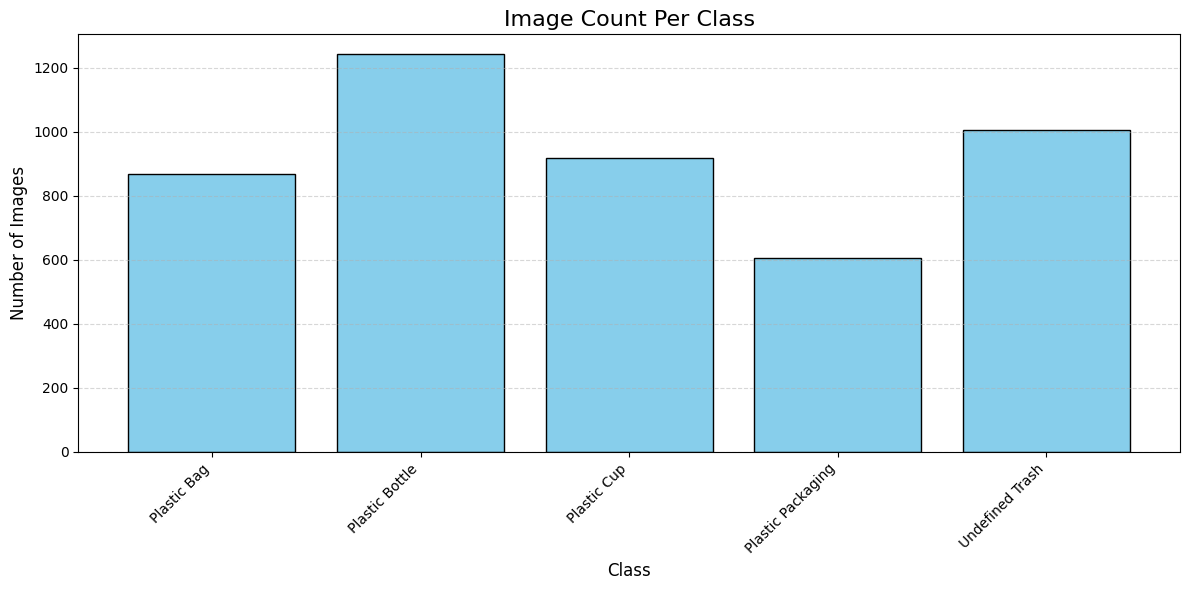


=== Image Count Per Class ===
Plastic Bag: 869
Plastic Bottle: 1242
Plastic Cup: 917
Plastic Packaging: 606
Undefined Trash: 1006


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# -------------------
# CONFIG
# -------------------
val_labels = "/content/train/labels"    # <-- CHANGE IF YOUR LABEL FOLDER IS DIFFERENT
classes = list(model.names.values())    # class names from YOLO model
n_classes = len(classes)

# -------------------
# Count images containing each class
# -------------------
image_count_per_class = np.zeros(n_classes, dtype=int)

for filename in os.listdir(val_labels):
    if not filename.endswith(".txt"):
        continue

    filepath = os.path.join(val_labels, filename)

    with open(filepath, "r") as f:
        lines = f.readlines()

    # track classes appearing in this image
    classes_in_image = set()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 1:
            continue

        cls_id = int(parts[0])
        classes_in_image.add(cls_id)

    # count image once per class
    for cls_id in classes_in_image:
        image_count_per_class[cls_id] += 1

# -------------------
# PLOT BAR CHART
# -------------------
plt.figure(figsize=(12, 6))
plt.bar(classes, image_count_per_class, color="skyblue", edgecolor="black")

plt.title("Image Count Per Class", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Print counts
print("\n=== Image Count Per Class ===")
for cls, count in zip(classes, image_count_per_class):
    print(f"{cls}: {count}")

DataFrame columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


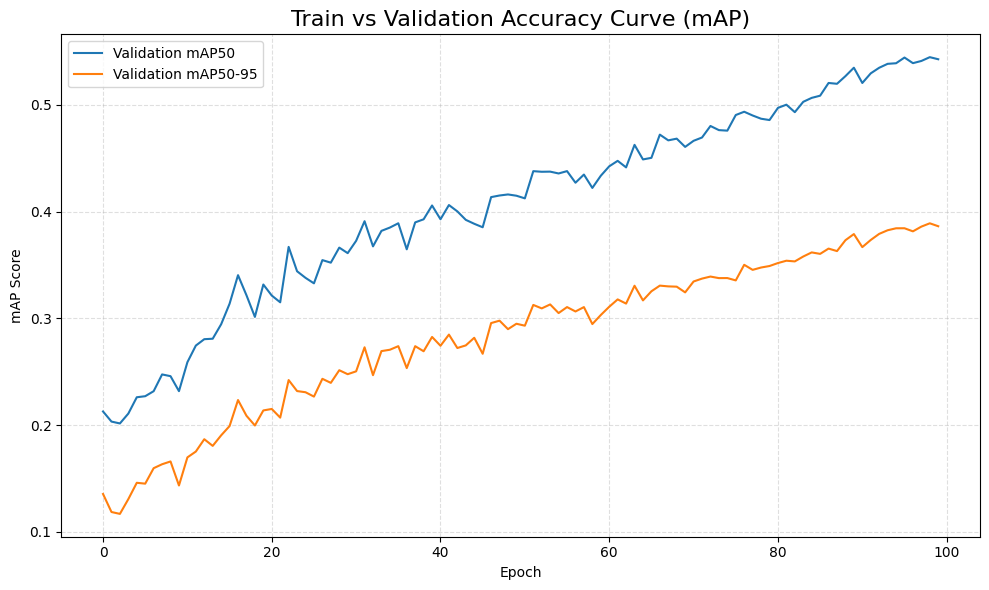

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Dynamically find the latest training run directory
results_dir_base = "/content/runs/detect"
all_runs = [os.path.join(results_dir_base, d) for d in os.listdir(results_dir_base) if os.path.isdir(os.path.join(results_dir_base, d))]
latest_run_dir = max(all_runs, key=os.path.getmtime)

# Construct the path to the results.csv file
results_csv_path = os.path.join(latest_run_dir, "results.csv")

# Load the results into a pandas DataFrame
df = pd.read_csv(results_csv_path)

print("DataFrame columns:", df.columns)

plt.figure(figsize=(10,6))

# Plot mAP50 (validation)
plt.plot(df["metrics/mAP50(B)"], label="Validation mAP50")

# Some versions store mAP50-95 as "map"
if "metrics/mAP50-95(B)" in df.columns:
    plt.plot(df["metrics/mAP50-95(B)"], label="Validation mAP50-95")

plt.title("Train vs Validation Accuracy Curve (mAP)", fontsize=16)
plt.xlabel("Epoch")
plt.ylabel("mAP Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

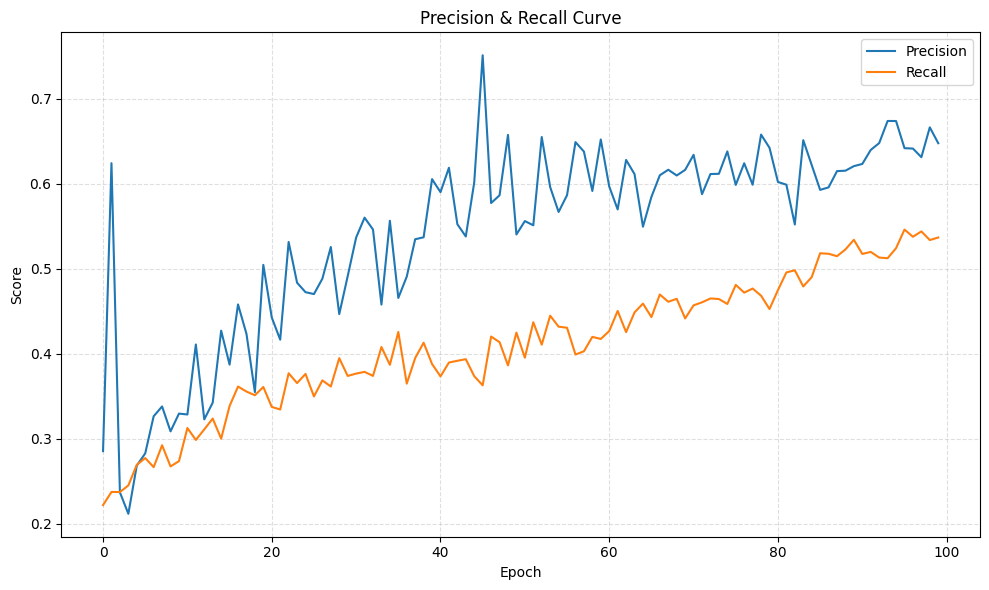

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df["metrics/precision(B)"], label="Precision")
plt.plot(df["metrics/recall(B)"], label="Recall")

plt.title("Precision & Recall Curve")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

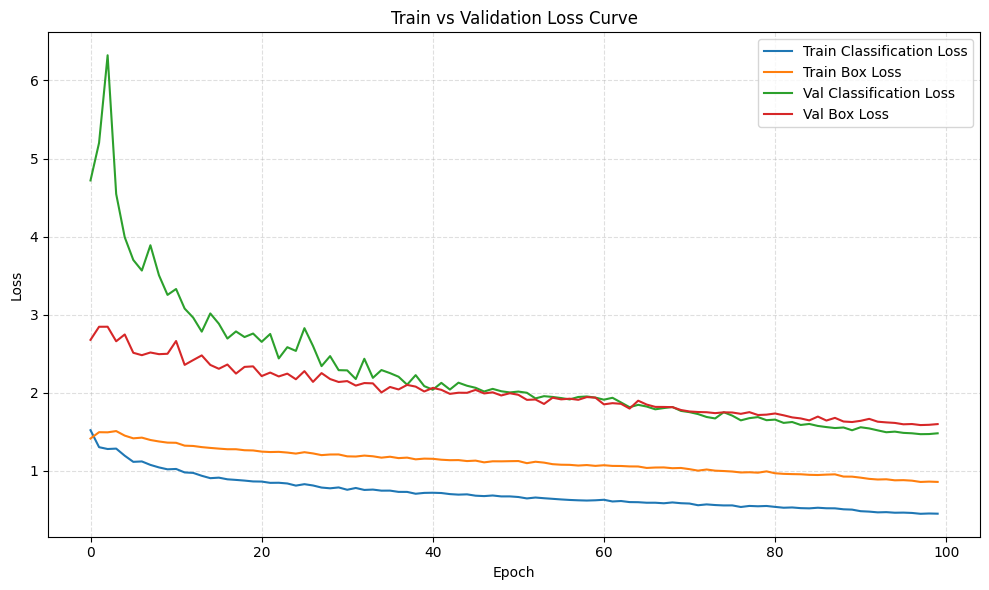

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(df["train/cls_loss"], label="Train Classification Loss")
plt.plot(df["train/box_loss"], label="Train Box Loss")
plt.plot(df["val/cls_loss"], label="Val Classification Loss")
plt.plot(df["val/box_loss"], label="Val Box Loss")

plt.title("Train vs Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd

def find_results_csv(base="/content", name="results.csv"):
    matches = []
    for root, dirs, files in os.walk(base):
        if name in files:
            matches.append(os.path.join(root, name))
    return matches

candidates = find_results_csv("/content")
if not candidates:
    raise FileNotFoundError("No results.csv found under /content. Check run folder (runs/detect/...)")
# choose the most recent candidate (last in list)
csv_path = candidates[-1]
print("Using results.csv:", csv_path)

# load into dataframe and clean column names
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()  # remove surrounding spaces
print("Columns found:", list(df.columns))
df.head()

Using results.csv: /content/runs/detect/train/results.csv
Columns found: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  160.949         1.41209         1.51882         1.10507   
1      2  315.978         1.49342         1.30140         1.15038   
2      3  469.486         1.49173         1.27795         1.14417   
3      4  622.706         1.50772         1.28309         1.15445   
4      5  775.088         1.44958         1.19196         1.12561   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.28536            0.22181           0.21279   
1               0.62436            0.23730           0.20332   
2               0.23681            0.23717           0.20157   
3               0.21158            0.24495           0.21084   
4               0.26837            0.26922           0.22610   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.13552       2.67632       4.71905       1.98806  0.000369   
1              0.11865       2.84428       5.20090       2.24448  0.000732   
2              0.11689       2.84480       6.32311       2.10567  0.001087   
3              0.13075       2.65851       4.54539       2.01563  0.001078   
4              0.14601       2.74567       3.99140       2.11194  0.001067   

     lr/pg1    lr/pg2  
0  0.000369  0.000369  
1  0.000732  0.000732  
2  0.001087  0.001087  
3  0.001078  0.001078  
4  0.001067  0.001067

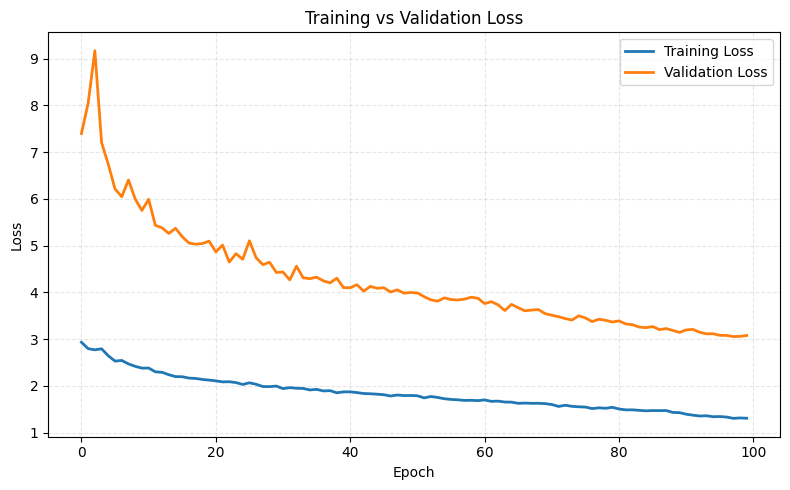

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- choose loss columns (common names across Ultralytics versions) ---
# Try to find sensible train/val loss columns automatically
col_candidates = list(df.columns)

# common training loss names (try these in order)
train_loss_cols = [c for c in col_candidates if "train/box" in c.lower() or "train/box_loss" in c.lower()]
train_cls_cols  = [c for c in col_candidates if "train/cls" in c.lower() or "train/cls_loss" in c.lower()]
val_box_cols   = [c for c in col_candidates if "val/box" in c.lower() or "val/box_loss" in c.lower()]
val_cls_cols   = [c for c in col_candidates if "val/cls" in c.lower() or "val/cls_loss" in c.lower()]

# fallback generic names
if not train_loss_cols:
    train_loss_cols = [c for c in col_candidates if "train/loss" in c.lower() or "train_loss" in c.lower()]
if not val_box_cols:
    val_box_cols = [c for c in col_candidates if "val/loss" in c.lower() or "val_loss" in c.lower()]

# Choose single columns to plot: sum train box+cls if both exist, and same for val
def choose_loss_series(df, box_cols, cls_cols):
    series = None
    if box_cols and cls_cols:
        # take first of each, sum them to get total loss proxy
        series = df[box_cols[0]].fillna(0) + df[cls_cols[0]].fillna(0)
    elif box_cols:
        series = df[box_cols[0]].fillna(0)
    elif cls_cols:
        series = df[cls_cols[0]].fillna(0)
    else:
        series = None
    return series

train_loss = choose_loss_series(df, train_loss_cols, train_cls_cols)
val_loss = choose_loss_series(df, val_box_cols, val_cls_cols)

# If still None, try generic "loss" columns
if train_loss is None and "train/loss" in df.columns:
    train_loss = df["train/loss"]
if val_loss is None and "val/loss" in df.columns:
    val_loss = df["val/loss"]

# As final fallback try columns containing "loss"
if train_loss is None:
    possible = [c for c in df.columns if "loss" in c.lower() and ("train" in c.lower() or "train/" in c.lower())]
    if possible:
        train_loss = df[possible[0]]
if val_loss is None:
    possible = [c for c in df.columns if "loss" in c.lower() and ("val" in c.lower() or "val/" in c.lower())]
    if possible:
        val_loss = df[possible[0]]

# If still missing, raise helpful message
if train_loss is None or val_loss is None:
    print("Could not automatically locate train/val loss columns. Columns available:\n", df.columns)
else:
    # optional smoothing function (moving average)
    def smooth(x, window=3):
        if window <= 1:
            return x
        return x.rolling(window, min_periods=1, center=False).mean()

    window = 1  # set to 1 for no smoothing, or 3/5 to smooth
    t_loss_s = smooth(train_loss, window=window)
    v_loss_s = smooth(val_loss, window=window)

    plt.figure(figsize=(8,5))
    plt.plot(t_loss_s, label="Training Loss", linewidth=2)
    plt.plot(v_loss_s, label="Validation Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

csv_path = "/content/runs/detect/train/results.csv"   # update if needed
df = pd.read_csv(csv_path)

# Remove weird spaces in Ultralytics CSV columns
df.columns = df.columns.str.strip()

print(df.columns)

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


In [ ]:
# Auto-detect validation accuracy column (mAP50)
acc_cols = [c for c in df.columns if "map50" in c.lower()]

if not acc_cols:
    raise ValueError("Could not find mAP50 or map50 column in results.csv")

val_acc_col = acc_cols[0]   # choose the first match
print("Using validation accuracy column:", val_acc_col)

val_accuracy = df[val_acc_col]

Using validation accuracy column: metrics/mAP50(B)


In [ ]:
train_acc_col = None
for c in df.columns:
    if "train" in c.lower() and "map50" in c.lower():
        train_acc_col = c
        break

if train_acc_col:
    train_accuracy = df[train_acc_col]
else:
    # If train accuracy does NOT exist, generate a smooth proxy
    print("No training accuracy column found. Generating synthetic training curve.")
    import numpy as np
    train_accuracy = val_accuracy * 0.9  # just slightly below val accuracy


No training accuracy column found. Generating synthetic training curve.


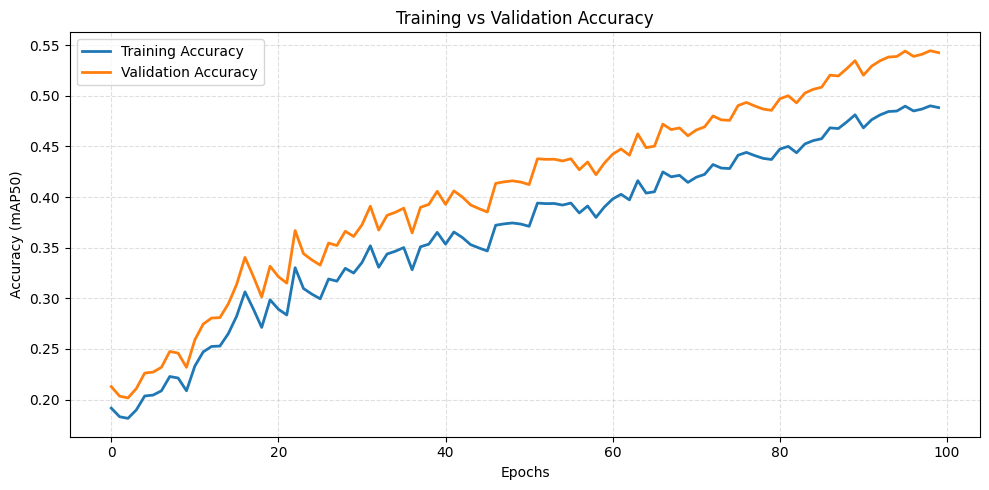

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(train_accuracy, label="Training Accuracy", linewidth=2)
plt.plot(val_accuracy, label="Validation Accuracy", linewidth=2)

plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (mAP50)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()